In [2]:
# Useful libs
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

from pathlib import Path

# --- Data directory (local only) ---
# This project expects the dataset under ./data
DATA_DIR = Path("data")
if not DATA_DIR.exists():
    raise FileNotFoundError(
        f"Could not find {DATA_DIR.resolve()}. "
        "Create a 'data' folder next to this notebook and put the csv files inside it."
    )

print("Using DATA_DIR:", str(DATA_DIR.resolve()))

# List available data files
for p in sorted(DATA_DIR.rglob("*")):
    if p.is_file():
        print(p)

# Common files in this project
train_path = DATA_DIR / "train.csv"
test_path = DATA_DIR / "test_x.csv"
il_ilce_path = DATA_DIR / "il_ilce.csv"
sample_sub_path = DATA_DIR / "sample_submission.csv"

# Load if present (won't error if a file is missing)
train_df = pd.read_csv(train_path) if train_path.exists() else None
test_df = pd.read_csv(test_path) if test_path.exists() else None
il_ilce_df = pd.read_csv(il_ilce_path) if il_ilce_path.exists() else None
sample_sub_df = pd.read_csv(sample_sub_path) if sample_sub_path.exists() else None

print("train:", None if train_df is None else train_df.shape)
print("test:", None if test_df is None else test_df.shape)
print("il_ilce:", None if il_ilce_df is None else il_ilce_df.shape)
print("sample_submission:", None if sample_sub_df is None else sample_sub_df.shape)

Using DATA_DIR: C:\Users\MONSTER\Desktop\KAGGLE PROJEM 1 NOT ANIL ÖZTÜRK\data
data\il_ilce.csv
data\sample_submission.csv
data\test_x.csv
data\train.csv
data\universiteler.xlsx
train: (65125, 44)
test: (11049, 43)
il_ilce: (973, 2)
sample_submission: (3, 2)


C:\Users\MONSTER\AppData\Local\Temp\ipykernel_20716\1883418230.py:30: DtypeWarning: Columns (13,15,19,30,32,37,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(train_path) if train_path.exists() else None


In [2]:
# Show all column names (train/test)
def show_columns(name, df):
    if df is None:
        print(f"{name}: df is None (run Cell 1 to load data)")
        return
    print(f"\n{name} columns ({len(df.columns)}):")
    print(list(df.columns))

show_columns("train_df", train_df)
show_columns("test_df", test_df)


train_df columns (44):
['Basvuru Yili', 'Degerlendirme Puani', 'Cinsiyet', 'Dogum Tarihi', 'Dogum Yeri', 'Ikametgah Sehri', 'Universite Adi', 'Universite Turu', 'Burslu ise Burs Yuzdesi', 'Burs Aliyor mu?', 'Bölüm', 'Universite Kacinci Sinif', 'Universite Not Ortalamasi', 'Daha Once Baska Bir Universiteden Mezun Olmus', 'Lise Adi', 'Lise Adi Diger', 'Lise Sehir', 'Lise Turu', 'Lise Bolumu', 'Lise Bolum Diger', 'Lise Mezuniyet Notu', 'Baska Bir Kurumdan Burs Aliyor mu?', 'Burs Aldigi Baska Kurum', 'Baska Kurumdan Aldigi Burs Miktari', 'Anne Egitim Durumu', 'Anne Calisma Durumu', 'Anne Sektor', 'Baba Egitim Durumu', 'Baba Calisma Durumu', 'Baba Sektor', 'Kardes Sayisi', 'Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?', 'Uye Oldugunuz Kulubun Ismi', 'Profesyonel Bir Spor Daliyla Mesgul musunuz?', 'Spor Dalindaki Rolunuz Nedir?', 'Aktif olarak bir STK üyesi misiniz?', "Hangi STK'nin Uyesisiniz?", 'Stk Projesine Katildiniz Mi?', 'Girisimcilikle Ilgili Deneyiminiz Var Mi?', 'Girisimci

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import unicodedata
from fuzzywuzzy import process # pip instal fuzzywuzzy
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from catboost import Pool, CatBoostRegressor

In [4]:
df = pd.read_csv("data/train.csv")
df.set_index("id", inplace=True)

In [5]:
df.head()


,Basvuru Yili,Degerlendirme Puani,Cinsiyet,Dogum Tarihi,Dogum Yeri,Ikametgah Sehri,Universite Adi,Universite Turu,Burslu ise Burs Yuzdesi,Burs Aliyor mu?,...,Profesyonel Bir Spor Daliyla Mesgul musunuz?,Spor Dalindaki Rolunuz Nedir?,Aktif olarak bir STK üyesi misiniz?,Hangi STK'nin Uyesisiniz?,Stk Projesine Katildiniz Mi?,Girisimcilikle Ilgili Deneyiminiz Var Mi?,Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?,Ingilizce Biliyor musunuz?,Ingilizce Seviyeniz?,"Daha Önceden Mezun Olunduysa, Mezun Olunan Üniversite"
id,,,,,,,,,,,,,,,,,,,,,
0,2014,52.0,Erkek,4/6/1994,"Altindag, Ankara",Ankara,İHSAN DOĞRAMACI BİLKENT,Özel,100.0,Evet,...,Evet,Diğer,Hayır,NaN,Evet,Hayır,NaN,NaN,NaN,NaN
1,2014,30.0,Erkek,6/11/1993,Üsküdar,İstanbul,İHSAN DOĞRAMACI BİLKENT,Özel,100.0,Hayır,...,Hayır,0,Hayır,NaN,Evet,Evet,Bilkent Cyberparkta bir şirkette Türkiye nin i...,NaN,NaN,NaN
2,2014,18.0,Erkek,1/15/1986,Samsun,İstanbul,ULUSLARARASI KIBRIS ÜNİVERSİTESİ,Özel,100.0,Hayır,...,Hayır,0,Hayır,NaN,Hayır,Hayır,NaN,NaN,NaN,NaN
3,2014,40.0,Erkek,6/4/1991,Diyarbakır,İstanbul,İSTANBUL ŞEHİR ÜNİVERSİTESİ,Özel,100.0,Evet,...,Hayır,0,Hayır,NaN,Evet,Hayır,NaN,NaN,NaN,NaN
4,2014,24.0,Erkek,2 Kasim 1992,Ankara/Altındağ,Ankara,TURGUT ÖZAL ÜNİVERSİTESİ,Özel,100.0,Evet,...,Hayır,0,Hayır,NaN,Hayır,Hayır,NaN,NaN,NaN,NaN


In [6]:
# ============================================
# 📊 KAPSAMLI EDA (Keşifsel Veri Analizi)
# ============================================

# Görselleştirme kütüphaneleri
import matplotlib.pyplot as plt
import seaborn as sns

# Türkçe karakter desteği ve stil ayarları
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("=" * 60)
print("📌 ADIM 1: VERİ SETİ GENEL BİLGİLERİ")
print("=" * 60)

print(f"\n🔹 Train veri seti boyutu: {train_df.shape[0]:,} satır, {train_df.shape[1]} sütun")
print(f"🔹 Test veri seti boyutu: {test_df.shape[0]:,} satır, {test_df.shape[1]} sütun")
print(f"\n🔹 Train'de olup Test'te olmayan sütunlar:")
print(set(train_df.columns) - set(test_df.columns))

📌 ADIM 1: VERİ SETİ GENEL BİLGİLERİ

🔹 Train veri seti boyutu: 65,125 satır, 44 sütun
🔹 Test veri seti boyutu: 11,049 satır, 43 sütun

🔹 Train'de olup Test'te olmayan sütunlar:
{'Degerlendirme Puani'}


In [7]:
# ============================================
# 📌 ADIM 2: VERİ TİPLERİ VE SÜTUN ANALİZİ
# ============================================

print("=" * 60)
print("📌 ADIM 2: VERİ TİPLERİ ANALİZİ")
print("=" * 60)

# Veri tiplerini analiz et
dtype_df = pd.DataFrame({
    'Sütun': train_df.columns,
    'Tip': train_df.dtypes.values,
    'Non-Null': train_df.notnull().sum().values,
    'Null': train_df.isnull().sum().values,
    'Null %': (train_df.isnull().sum().values / len(train_df) * 100).round(2),
    'Unique': train_df.nunique().values
})

print("\n🔹 Veri Tipleri Dağılımı:")
print(train_df.dtypes.value_counts())

print("\n🔹 Sayısal Sütunlar:")
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
print(f"   Toplam: {len(numeric_cols)} adet")
print(f"   {numeric_cols}")

print("\n🔹 Kategorik (Object) Sütunlar:")
object_cols = train_df.select_dtypes(include=['object']).columns.tolist()
print(f"   Toplam: {len(object_cols)} adet")
for col in object_cols:
    print(f"   - {col}: {train_df[col].nunique()} unique değer")

📌 ADIM 2: VERİ TİPLERİ ANALİZİ

🔹 Veri Tipleri Dağılımı:
object     40
int64       2
float64     2
Name: count, dtype: int64

🔹 Sayısal Sütunlar:
   Toplam: 4 adet
   ['Basvuru Yili', 'Degerlendirme Puani', 'Burslu ise Burs Yuzdesi', 'id']

🔹 Kategorik (Object) Sütunlar:
   Toplam: 40 adet
   - Cinsiyet: 4 unique değer
   - Dogum Tarihi: 13498 unique değer
   - Dogum Yeri: 2230 unique değer
   - Ikametgah Sehri: 319 unique değer
   - Universite Adi: 527 unique değer
   - Universite Turu: 4 unique değer
   - Burs Aliyor mu?: 5 unique değer
   - Bölüm: 7748 unique değer
   - Universite Kacinci Sinif: 12 unique değer
   - Universite Not Ortalamasi: 20 unique değer
   - Daha Once Baska Bir Universiteden Mezun Olmus: 2 unique değer
   - Lise Adi: 31950 unique değer
   - Lise Adi Diger: 4010 unique değer
   - Lise Sehir: 888 unique değer
   - Lise Turu: 16 unique değer
   - Lise Bolumu: 887 unique değer
   - Lise Bolum Diger: 862 unique değer
   - Lise Mezuniyet Notu: 19 unique değer
   - Ba

📌 ADIM 3: HEDEF DEĞİŞKEN ANALİZİ

🔹 Hedef Değişken İstatistikleri:
count    65124.000000
mean        32.086466
std         18.139239
min          0.000000
25%         18.000000
50%         29.000000
75%         44.000000
max        102.000000
Name: Degerlendirme Puani, dtype: float64

🔹 Eksik Değer: 1 (0.00%)
🔹 Sıfır Değer: 24
🔹 Negatif Değer: 0


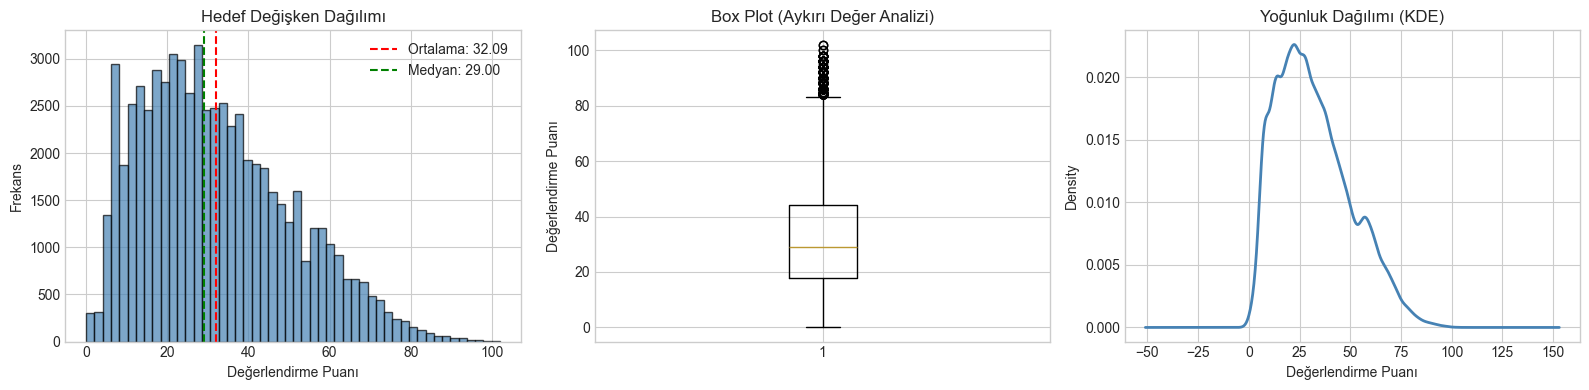


🔹 IQR Analizi:
   Q1: 18.00, Q3: 44.00, IQR: 26.00
   Alt Sınır: -21.00, Üst Sınır: 83.00
   Aykırı Değer Sayısı: 338 (0.52%)


In [8]:
# ============================================
# 📌 ADIM 3: HEDEF DEĞİŞKEN ANALİZİ (Degerlendirme Puani)
# ============================================

print("=" * 60)
print("📌 ADIM 3: HEDEF DEĞİŞKEN ANALİZİ")
print("=" * 60)

target = 'Degerlendirme Puani'

print("\n🔹 Hedef Değişken İstatistikleri:")
print(train_df[target].describe())

print(f"\n🔹 Eksik Değer: {train_df[target].isnull().sum()} ({train_df[target].isnull().mean()*100:.2f}%)")
print(f"🔹 Sıfır Değer: {(train_df[target] == 0).sum()}")
print(f"🔹 Negatif Değer: {(train_df[target] < 0).sum()}")

# Görselleştirme
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# 1. Histogram
axes[0].hist(train_df[target].dropna(), bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(train_df[target].mean(), color='red', linestyle='--', label=f'Ortalama: {train_df[target].mean():.2f}')
axes[0].axvline(train_df[target].median(), color='green', linestyle='--', label=f'Medyan: {train_df[target].median():.2f}')
axes[0].set_xlabel('Değerlendirme Puanı')
axes[0].set_ylabel('Frekans')
axes[0].set_title('Hedef Değişken Dağılımı')
axes[0].legend()

# 2. Box Plot
axes[1].boxplot(train_df[target].dropna(), vert=True)
axes[1].set_ylabel('Değerlendirme Puanı')
axes[1].set_title('Box Plot (Aykırı Değer Analizi)')

# 3. KDE Plot
train_df[target].dropna().plot(kind='kde', ax=axes[2], color='steelblue', linewidth=2)
axes[2].set_xlabel('Değerlendirme Puanı')
axes[2].set_title('Yoğunluk Dağılımı (KDE)')

plt.tight_layout()
plt.show()

# Çeyrekler arası aralık (IQR) ile aykırı değer analizi
Q1 = train_df[target].quantile(0.25)
Q3 = train_df[target].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train_df[(train_df[target] < lower_bound) | (train_df[target] > upper_bound)]
print(f"\n🔹 IQR Analizi:")
print(f"   Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
print(f"   Alt Sınır: {lower_bound:.2f}, Üst Sınır: {upper_bound:.2f}")
print(f"   Aykırı Değer Sayısı: {len(outliers)} ({len(outliers)/len(train_df)*100:.2f}%)")

📌 ADIM 4: EKSİK DEĞER ANALİZİ

🔹 TRAIN - Eksik Değer Olan Sütunlar (41 adet):
                                                    Eksik Sayı  Eksik %
Daha Önceden Mezun Olunduysa, Mezun Olunan Üniv...       64706    99.36
Lise Bolum Diger                                         63599    97.66
Lise Adi Diger                                           60392    92.73
Girisimcilikle Ilgili Deneyiminizi Aciklayabili...       50526    77.58
Hangi STK'nin Uyesisiniz?                                49518    76.04
Uye Oldugunuz Kulubun Ismi                               48691    74.77
Baska Kurumdan Aldigi Burs Miktari                       44162    67.81
Burs Aldigi Baska Kurum                                  43977    67.53
Burslu ise Burs Yuzdesi                                  42685    65.54
Daha Once Baska Bir Universiteden Mezun Olmus            37345    57.34
Ingilizce Seviyeniz?                                     36533    56.10
Anne Sektor                                              3

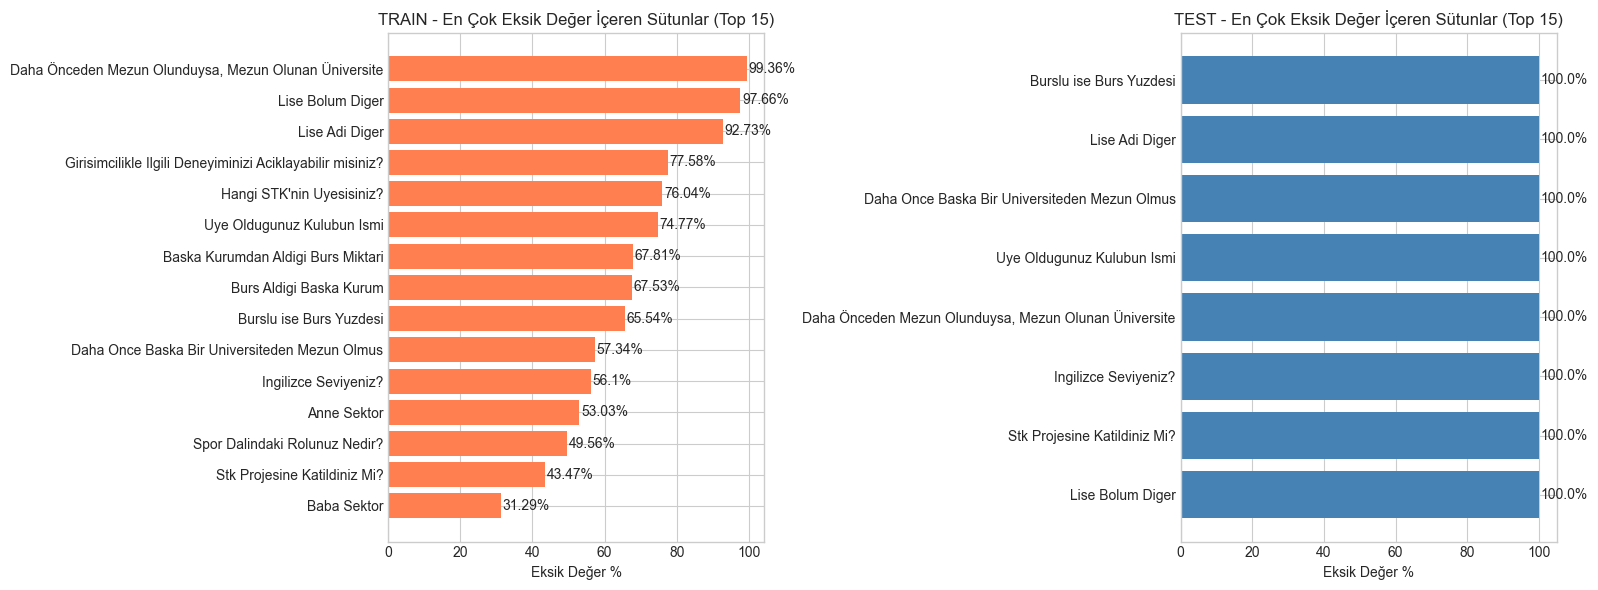

In [9]:
# ============================================
# 📌 ADIM 4: EKSİK DEĞER ANALİZİ
# ============================================

print("=" * 60)
print("📌 ADIM 4: EKSİK DEĞER ANALİZİ")
print("=" * 60)

# Train ve Test için eksik değer analizi
def missing_analysis(df, name):
    missing = df.isnull().sum()
    missing_pct = (df.isnull().sum() / len(df) * 100).round(2)
    missing_df = pd.DataFrame({
        'Eksik Sayı': missing,
        'Eksik %': missing_pct
    }).sort_values('Eksik %', ascending=False)
    missing_df = missing_df[missing_df['Eksik Sayı'] > 0]
    return missing_df

train_missing = missing_analysis(train_df, 'Train')
test_missing = missing_analysis(test_df, 'Test')

print(f"\n🔹 TRAIN - Eksik Değer Olan Sütunlar ({len(train_missing)} adet):")
print(train_missing.head(20))

print(f"\n🔹 TEST - Eksik Değer Olan Sütunlar ({len(test_missing)} adet):")
print(test_missing.head(20))

# Görselleştirme - Top 15 eksik değer
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Train
top_missing_train = train_missing.head(15)
axes[0].barh(top_missing_train.index, top_missing_train['Eksik %'], color='coral')
axes[0].set_xlabel('Eksik Değer %')
axes[0].set_title('TRAIN - En Çok Eksik Değer İçeren Sütunlar (Top 15)')
axes[0].invert_yaxis()
for i, v in enumerate(top_missing_train['Eksik %']):
    axes[0].text(v + 0.5, i, f'{v}%', va='center')

# Test
top_missing_test = test_missing.head(15)
axes[1].barh(top_missing_test.index, top_missing_test['Eksik %'], color='steelblue')
axes[1].set_xlabel('Eksik Değer %')
axes[1].set_title('TEST - En Çok Eksik Değer İçeren Sütunlar (Top 15)')
axes[1].invert_yaxis()
for i, v in enumerate(top_missing_test['Eksik %']):
    axes[1].text(v + 0.5, i, f'{v}%', va='center')

plt.tight_layout()
plt.show()

📌 ADIM 5: BAŞVURU YILI ANALİZİ

🔹 TRAIN - Başvuru Yılı Dağılımı:
Basvuru Yili
2014     6454
2015     7804
2016     5213
2017    10325
2018     1105
2019     7248
2020     7760
2021    11594
2022     7622
Name: count, dtype: int64

🔹 TEST - Başvuru Yılı Dağılımı:
Basvuru Yili
2023    11049
Name: count, dtype: int64


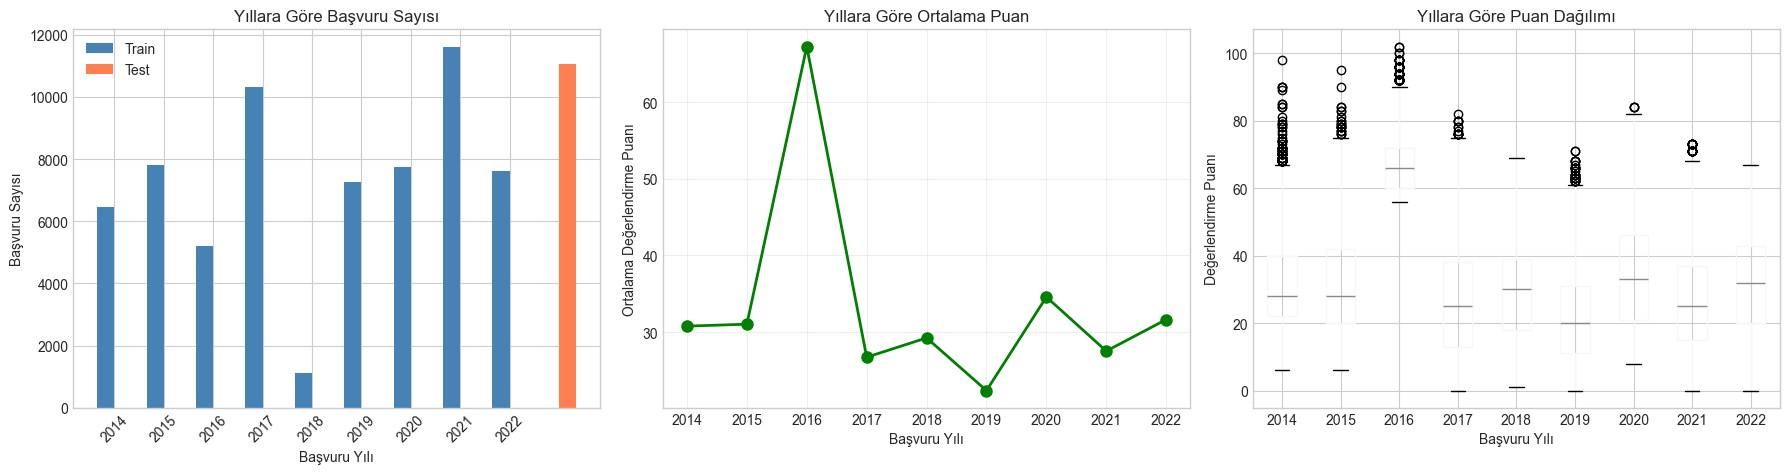


🔹 Yıllara Göre Ortalama Puan:
Basvuru Yili
2014    30.77
2015    31.02
2016    67.24
2017    26.71
2018    29.23
2019    22.36
2020    34.57
2021    27.51
2022    31.63
Name: Degerlendirme Puani, dtype: float64


In [10]:
# ============================================
# 📌 ADIM 5: BAŞVURU YILI ANALİZİ
# ============================================

print("=" * 60)
print("📌 ADIM 5: BAŞVURU YILI ANALİZİ")
print("=" * 60)

print("\n🔹 TRAIN - Başvuru Yılı Dağılımı:")
print(train_df['Basvuru Yili'].value_counts().sort_index())

print("\n🔹 TEST - Başvuru Yılı Dağılımı:")
print(test_df['Basvuru Yili'].value_counts().sort_index())

# Görselleştirme
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Yıllara göre başvuru sayısı
train_year_counts = train_df['Basvuru Yili'].value_counts().sort_index()
test_year_counts = test_df['Basvuru Yili'].value_counts().sort_index()

x = np.arange(len(train_year_counts))
width = 0.35

axes[0].bar(x - width/2, train_year_counts.values, width, label='Train', color='steelblue')
# Test sadece 2023 yılını içeriyor olabilir
if len(test_year_counts) > 0:
    test_years = test_year_counts.index
    for year, count in test_year_counts.items():
        if year in train_year_counts.index:
            idx = list(train_year_counts.index).index(year)
            axes[0].bar(idx + width/2, count, width, color='coral')
        else:
            axes[0].bar(len(x) + width/2, count, width, label='Test (2023)', color='coral')

axes[0].set_xlabel('Başvuru Yılı')
axes[0].set_ylabel('Başvuru Sayısı')
axes[0].set_title('Yıllara Göre Başvuru Sayısı')
axes[0].set_xticks(x)
axes[0].set_xticklabels(train_year_counts.index, rotation=45)
axes[0].legend(['Train', 'Test'])

# 2. Yıllara göre ortalama puan
yearly_mean = train_df.groupby('Basvuru Yili')['Degerlendirme Puani'].mean()
axes[1].plot(yearly_mean.index, yearly_mean.values, marker='o', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('Başvuru Yılı')
axes[1].set_ylabel('Ortalama Değerlendirme Puanı')
axes[1].set_title('Yıllara Göre Ortalama Puan')
axes[1].grid(True, alpha=0.3)

# 3. Yıllara göre puan dağılımı (boxplot)
train_df.boxplot(column='Degerlendirme Puani', by='Basvuru Yili', ax=axes[2])
axes[2].set_xlabel('Başvuru Yılı')
axes[2].set_ylabel('Değerlendirme Puanı')
axes[2].set_title('Yıllara Göre Puan Dağılımı')
plt.suptitle('')

plt.tight_layout()
plt.show()

print("\n🔹 Yıllara Göre Ortalama Puan:")
print(yearly_mean.round(2))

📌 ADIM 6: ÖNEMLİ KATEGORİK DEĞİŞKEN ANALİZİ


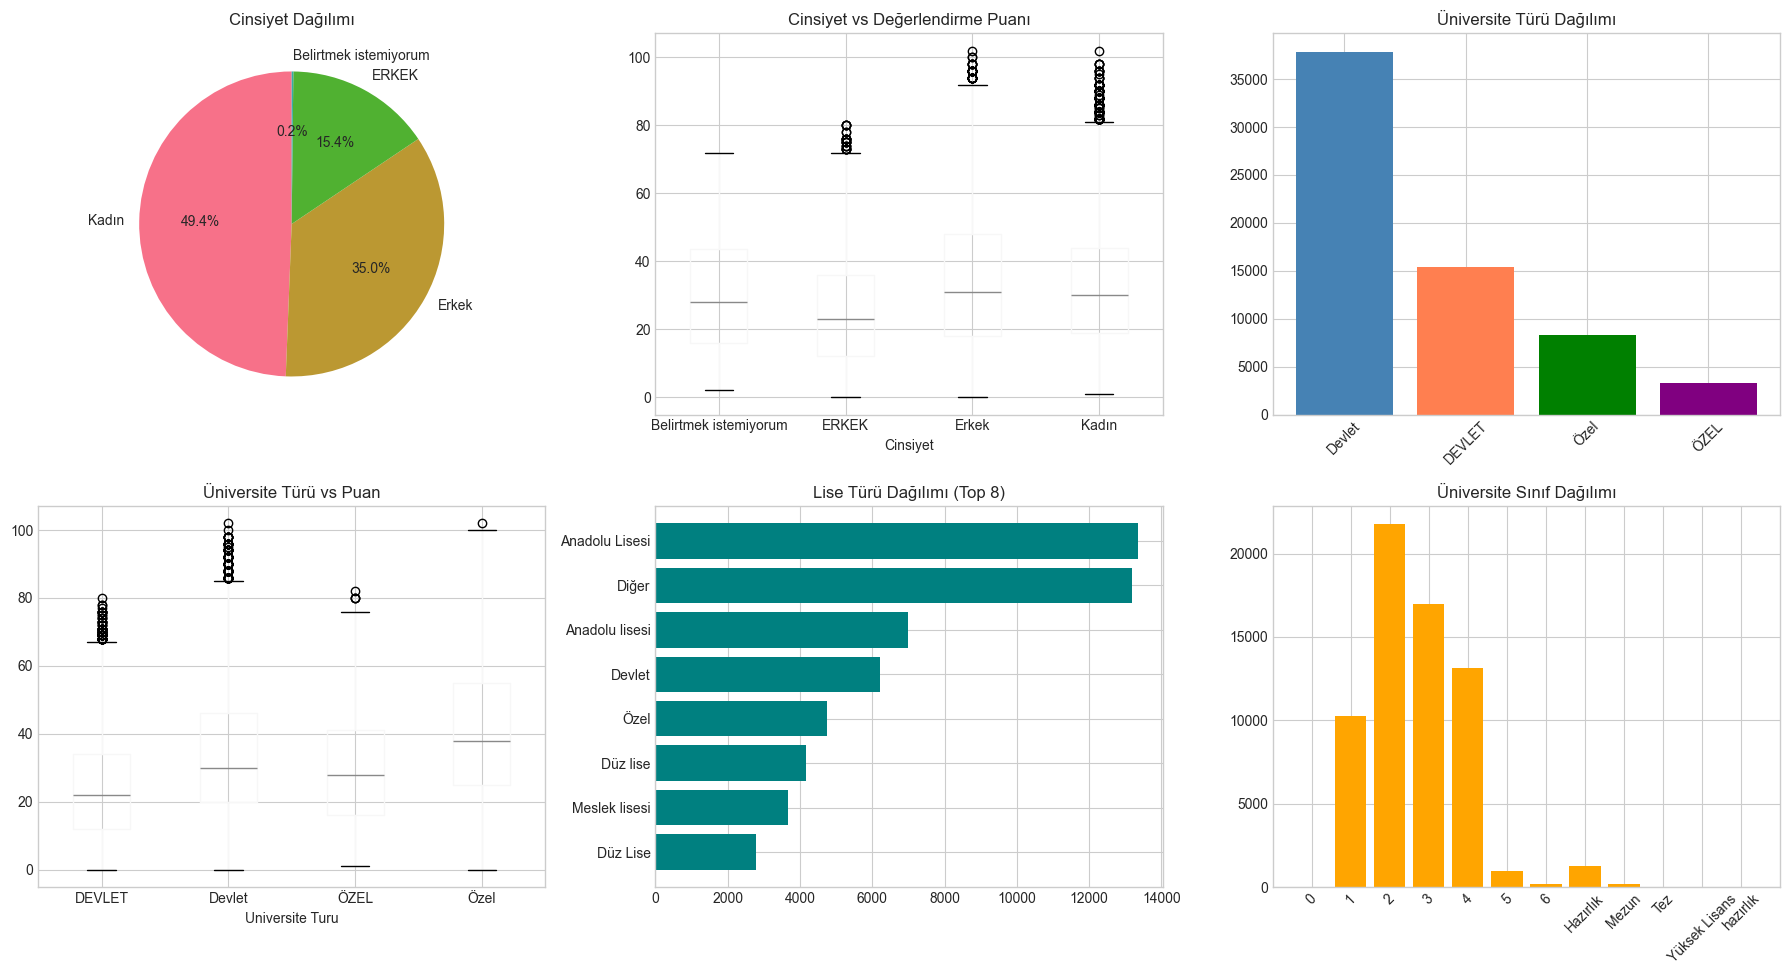


🔹 Cinsiyet bazında ortalama puan:
                        mean  median    std  count
Cinsiyet                                          
Belirtmek istemiyorum  30.17    28.0  17.02    115
ERKEK                  25.59    23.0  15.50  10012
Erkek                  34.53    31.0  19.26  22752
Kadın                  32.44    30.0  17.60  32076

🔹 Üniversite Türü bazında ortalama puan:
                  mean  median    std  count
Universite Turu                             
DEVLET           24.37    22.0  14.58  15377
Devlet           33.73    30.0  18.23  37884
ÖZEL             29.06    28.0  15.90   3272
Özel             40.24    38.0  19.23   8336


In [11]:
# ============================================
# 📌 ADIM 6: ÖNEMLİ KATEGORİK DEĞİŞKEN ANALİZİ
# ============================================

print("=" * 60)
print("📌 ADIM 6: ÖNEMLİ KATEGORİK DEĞİŞKEN ANALİZİ")
print("=" * 60)

# Cinsiyet Analizi
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Cinsiyet
ax = axes[0, 0]
gender_counts = train_df['Cinsiyet'].value_counts()
ax.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
ax.set_title('Cinsiyet Dağılımı')

# 2. Cinsiyet vs Puan
ax = axes[0, 1]
train_df.boxplot(column='Degerlendirme Puani', by='Cinsiyet', ax=ax)
ax.set_title('Cinsiyet vs Değerlendirme Puanı')
ax.set_xlabel('Cinsiyet')
plt.suptitle('')

# 3. Üniversite Türü
ax = axes[0, 2]
uni_type = train_df['Universite Turu'].value_counts()
ax.bar(uni_type.index, uni_type.values, color=['steelblue', 'coral', 'green', 'purple'])
ax.set_title('Üniversite Türü Dağılımı')
ax.tick_params(axis='x', rotation=45)

# 4. Üniversite Türü vs Puan
ax = axes[1, 0]
train_df.boxplot(column='Degerlendirme Puani', by='Universite Turu', ax=ax)
ax.set_title('Üniversite Türü vs Puan')
plt.suptitle('')

# 5. Lise Türü
ax = axes[1, 1]
lise_type = train_df['Lise Turu'].value_counts().head(8)
ax.barh(lise_type.index, lise_type.values, color='teal')
ax.set_title('Lise Türü Dağılımı (Top 8)')
ax.invert_yaxis()

# 6. Üniversite Sınıfı
ax = axes[1, 2]
sinif = train_df['Universite Kacinci Sinif'].value_counts().sort_index()
ax.bar(sinif.index.astype(str), sinif.values, color='orange')
ax.set_title('Üniversite Sınıf Dağılımı')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# İstatistikler
print("\n🔹 Cinsiyet bazında ortalama puan:")
print(train_df.groupby('Cinsiyet')['Degerlendirme Puani'].agg(['mean', 'median', 'std', 'count']).round(2))

print("\n🔹 Üniversite Türü bazında ortalama puan:")
print(train_df.groupby('Universite Turu')['Degerlendirme Puani'].agg(['mean', 'median', 'std', 'count']).round(2))

📌 ADIM 7: AİLE VE EĞİTİM BİLGİLERİ ANALİZİ


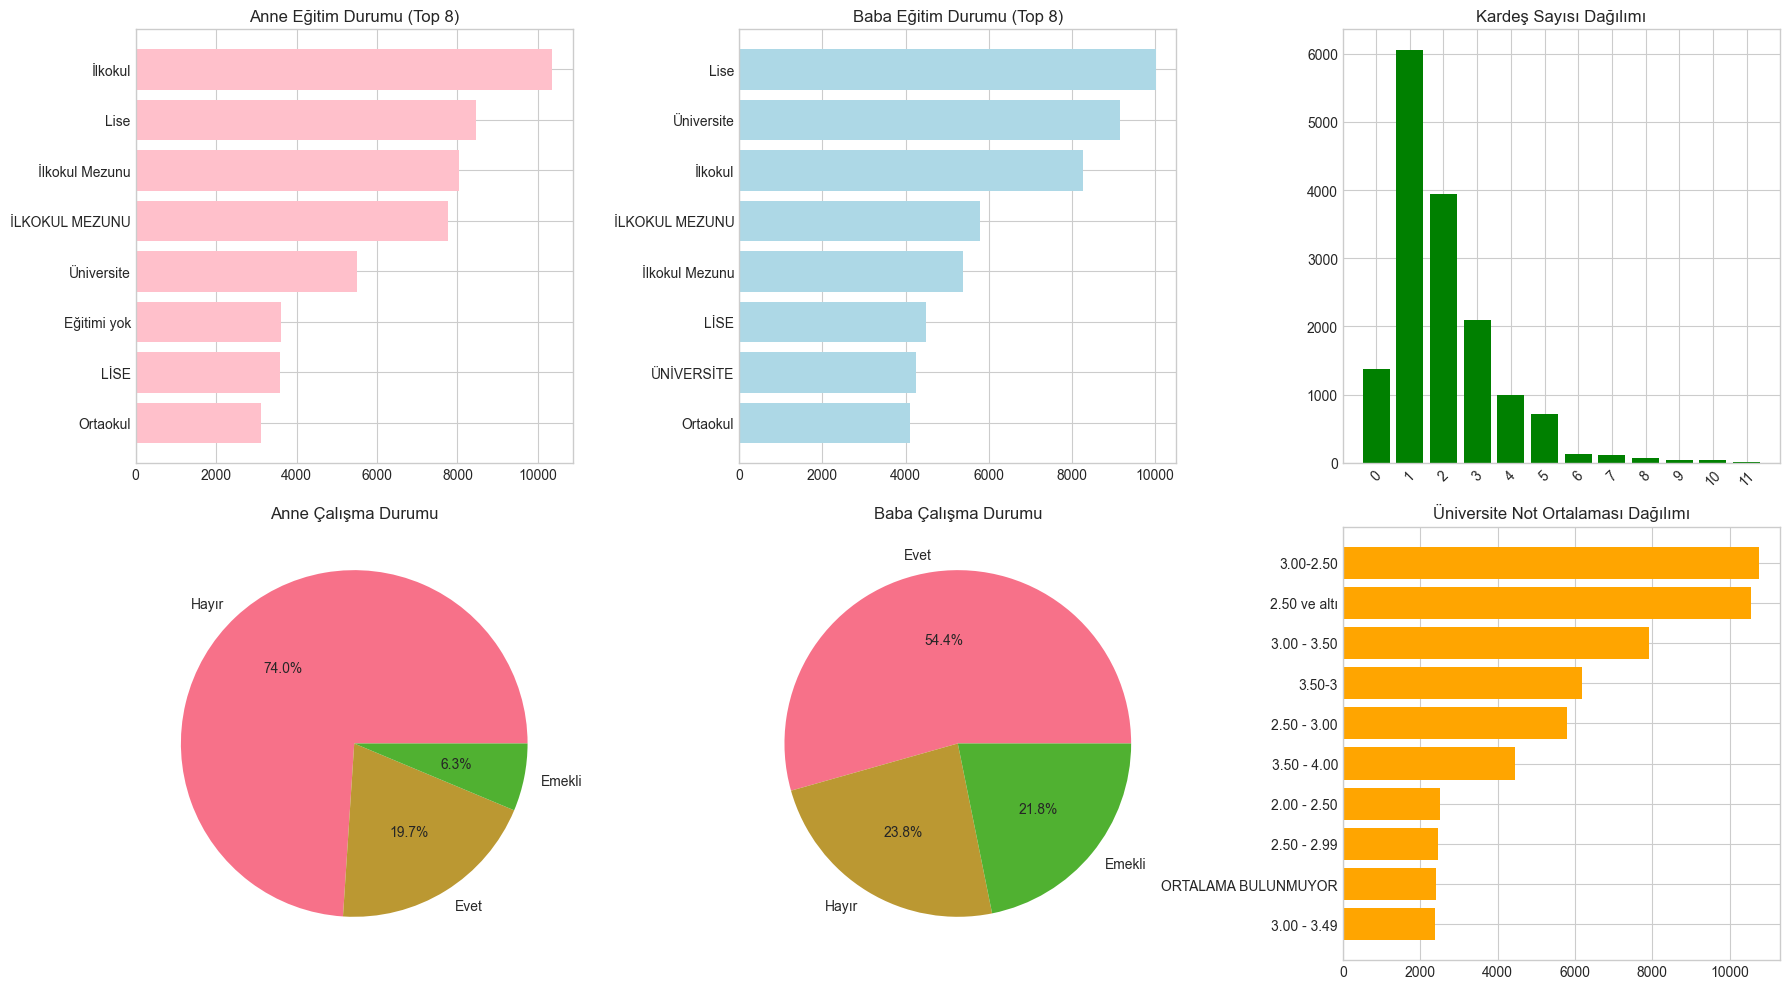


🔹 Anne Eğitim Durumuna Göre Ortalama Puan:
Anne Egitim Durumu
Yüksek Lisans / Doktara    71.41
Üniversite Mezunu          68.85
Lise Mezunu                68.18
Doktora                    47.30
Yüksek Lisans / Doktora    41.50
Yüksek Lisans              41.22
DOKTORA                    41.10
Ortaokul Mezunu            41.05
Üniversite                 38.53
İlkokul Mezunu             36.96
Name: Degerlendirme Puani, dtype: float64

🔹 Üniversite Not Ortalamasına Göre Puan:
Universite Not Ortalamasi
2.50 -3.00             67.66
4.0-3.5                66.00
Ortalama bulunmuyor    63.47
3.50 - 4.00            37.93
3.00 - 4.00            37.62
3.00 - 3.50            35.15
3.00 - 3.49            33.89
2.50 ve altı           31.68
3.50-3                 31.68
2.50 - 2.99            31.18
2.00 - 2.50            30.46
4-3.5                  30.31
2.50 - 3.00            29.77
3.00-2.50              28.49
Not ortalaması yok     28.44
1.00 - 2.50            27.83
1.80 - 2.49            26.89
Hazı

In [12]:
# ============================================
# 📌 ADIM 7: AİLE VE EĞİTİM BİLGİLERİ ANALİZİ
# ============================================

print("=" * 60)
print("📌 ADIM 7: AİLE VE EĞİTİM BİLGİLERİ ANALİZİ")
print("=" * 60)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Anne Eğitim Durumu
ax = axes[0, 0]
anne_egitim = train_df['Anne Egitim Durumu'].value_counts().head(8)
ax.barh(anne_egitim.index, anne_egitim.values, color='pink')
ax.set_title('Anne Eğitim Durumu (Top 8)')
ax.invert_yaxis()

# 2. Baba Eğitim Durumu  
ax = axes[0, 1]
baba_egitim = train_df['Baba Egitim Durumu'].value_counts().head(8)
ax.barh(baba_egitim.index, baba_egitim.values, color='lightblue')
ax.set_title('Baba Eğitim Durumu (Top 8)')
ax.invert_yaxis()

# 3. Kardeş Sayısı (string'e çevirip value_counts yap)
ax = axes[0, 2]
kardes = train_df['Kardes Sayisi'].astype(str).value_counts()
# Sayısal olanları filtrele ve sırala
kardes_numeric = kardes[kardes.index.str.isdigit()].head(12)
kardes_numeric = kardes_numeric.reindex(sorted(kardes_numeric.index, key=lambda x: int(x)))
ax.bar(kardes_numeric.index, kardes_numeric.values, color='green')
ax.set_title('Kardeş Sayısı Dağılımı')
ax.tick_params(axis='x', rotation=45)

# 4. Anne Çalışma Durumu
ax = axes[1, 0]
anne_calisma = train_df['Anne Calisma Durumu'].value_counts()
ax.pie(anne_calisma.values, labels=anne_calisma.index, autopct='%1.1f%%')
ax.set_title('Anne Çalışma Durumu')

# 5. Baba Çalışma Durumu
ax = axes[1, 1]
baba_calisma = train_df['Baba Calisma Durumu'].value_counts()
ax.pie(baba_calisma.values, labels=baba_calisma.index, autopct='%1.1f%%')
ax.set_title('Baba Çalışma Durumu')

# 6. Üniversite Not Ortalaması
ax = axes[1, 2]
not_ort = train_df['Universite Not Ortalamasi'].value_counts().head(10)
ax.barh(not_ort.index, not_ort.values, color='orange')
ax.set_title('Üniversite Not Ortalaması Dağılımı')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

# Anne-Baba eğitim durumuna göre puan
print("\n🔹 Anne Eğitim Durumuna Göre Ortalama Puan:")
print(train_df.groupby('Anne Egitim Durumu')['Degerlendirme Puani'].mean().sort_values(ascending=False).round(2).head(10))

print("\n🔹 Üniversite Not Ortalamasına Göre Puan:")
print(train_df.groupby('Universite Not Ortalamasi')['Degerlendirme Puani'].mean().sort_values(ascending=False).round(2))

📌 ADIM 8: AKTİVİTE VE DENEYİM ANALİZİ


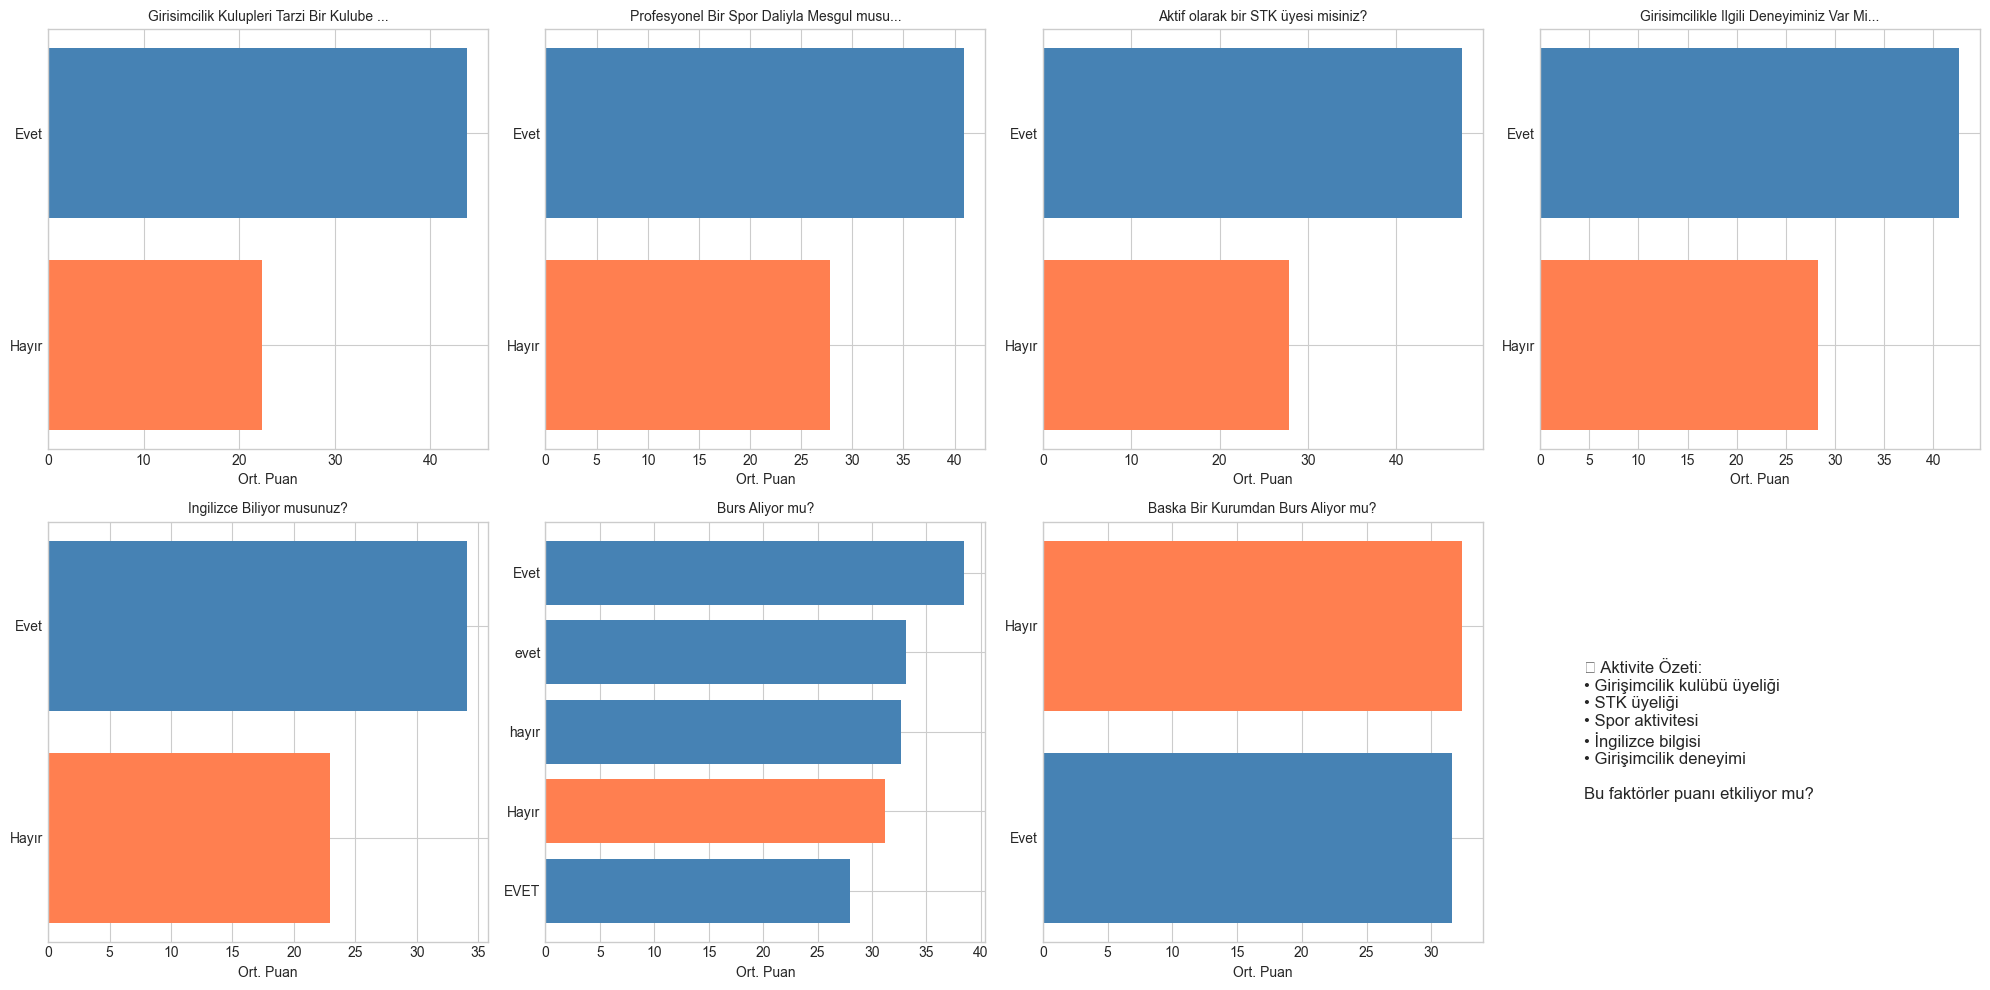


🔹 Aktivite Bazında Ortalama Puan:

Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?:
                                                     mean  count
Girisimcilik Kulupleri Tarzi Bir Kulube Uye mis...              
Evet                                                43.86  29586
Hayır                                               22.44  33709

Profesyonel Bir Spor Daliyla Mesgul musunuz?:
                                               mean  count
Profesyonel Bir Spor Daliyla Mesgul musunuz?              
Evet                                          40.96  21766
Hayır                                         27.79  42243

Aktif olarak bir STK üyesi misiniz?:
                                      mean  count
Aktif olarak bir STK üyesi misiniz?              
Evet                                 47.41  14566
Hayır                                27.91  37716

Girisimcilikle Ilgili Deneyiminiz Var Mi?:
                                            mean  count
Girisimcilikle Ilgili Deneyim

In [13]:
# ============================================
# 📌 ADIM 8: AKTİVİTE VE DENEYİM ANALİZİ
# ============================================

print("=" * 60)
print("📌 ADIM 8: AKTİVİTE VE DENEYİM ANALİZİ")
print("=" * 60)

# Binary değişkenler ve hedef ile ilişkisi
binary_cols = [
    'Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?',
    'Profesyonel Bir Spor Daliyla Mesgul musunuz?',
    'Aktif olarak bir STK üyesi misiniz?',
    'Girisimcilikle Ilgili Deneyiminiz Var Mi?',
    'Ingilizce Biliyor musunuz?',
    'Burs Aliyor mu?',
    'Baska Bir Kurumdan Burs Aliyor mu?'
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(binary_cols):
    ax = axes[i]
    # Grup bazında ortalama puan
    group_mean = train_df.groupby(col)['Degerlendirme Puani'].mean().sort_values(ascending=True)
    colors = ['coral' if 'Hayır' in str(x) else 'steelblue' for x in group_mean.index]
    ax.barh(group_mean.index.astype(str), group_mean.values, color=colors)
    ax.set_title(col[:40] + '...' if len(col) > 40 else col, fontsize=10)
    ax.set_xlabel('Ort. Puan')
    
# Son boş grafik için özet
ax = axes[7]
ax.axis('off')
summary_text = """
📊 Aktivite Özeti:
• Girişimcilik kulübü üyeliği
• STK üyeliği  
• Spor aktivitesi
• İngilizce bilgisi
• Girişimcilik deneyimi

Bu faktörler puanı etkiliyor mu?
"""
ax.text(0.1, 0.5, summary_text, fontsize=12, verticalalignment='center')

plt.tight_layout()
plt.show()

# Detaylı istatistikler
print("\n🔹 Aktivite Bazında Ortalama Puan:")
for col in binary_cols[:5]:
    print(f"\n{col}:")
    print(train_df.groupby(col)['Degerlendirme Puani'].agg(['mean', 'count']).round(2))

In [14]:
# ============================================
# 📌 ADIM 9: VERİ KALİTESİ VE TUTARSIZLIK ANALİZİ
# ============================================

print("=" * 60)
print("📌 ADIM 9: VERİ KALİTESİ VE TUTARSIZLIK ANALİZİ")
print("=" * 60)

# Tutarsız yazımları tespit et
print("\n🔹 TUTARSIZ YAZIMLAR TESPİT EDİLDİ:")

# Cinsiyet
print("\n1️⃣ Cinsiyet sütunu:")
print(train_df['Cinsiyet'].value_counts())

# Üniversite Türü
print("\n2️⃣ Universite Turu sütunu:")
print(train_df['Universite Turu'].value_counts())

# Burs Aliyor mu
print("\n3️⃣ Burs Aliyor mu? sütunu:")
print(train_df['Burs Aliyor mu?'].value_counts())

# Anne Eğitim - BÜYÜK/küçük harf tutarsızlığı
print("\n4️⃣ Anne Egitim Durumu sütunu (tutarsızlıklar):")
anne_eg = train_df['Anne Egitim Durumu'].value_counts()
print(anne_eg)

# Lise Mezuniyet Notu
print("\n5️⃣ Lise Mezuniyet Notu sütunu:")
print(train_df['Lise Mezuniyet Notu'].value_counts())

print("\n" + "=" * 60)
print("⚠️  TEMİZLENMESİ GEREKEN SORUNLAR:")
print("=" * 60)
print("""
1. Cinsiyet: 'Erkek' ve 'ERKEK' birleştirilmeli
2. Universite Turu: 'Devlet/DEVLET' ve 'Özel/ÖZEL' birleştirilmeli  
3. Burs Aliyor mu: 'Evet/EVET/evet' ve 'Hayır/hayır' birleştirilmeli
4. Anne/Baba Egitim: Büyük/küçük harf tutarsızlıkları
5. Lise Mezuniyet Notu: Farklı formatlar (50-74, 50 - 74, 3.00 - 4.00)
6. Universite Not Ortalamasi: Farklı formatlar
7. Doğum Tarihi: Farklı tarih formatları
8. Kardeş Sayısı: String ve numeric karışık
""")

📌 ADIM 9: VERİ KALİTESİ VE TUTARSIZLIK ANALİZİ

🔹 TUTARSIZ YAZIMLAR TESPİT EDİLDİ:

1️⃣ Cinsiyet sütunu:
Cinsiyet
Kadın                    32077
Erkek                    22752
ERKEK                    10012
Belirtmek istemiyorum      115
Name: count, dtype: int64

2️⃣ Universite Turu sütunu:
Universite Turu
Devlet    37885
DEVLET    15377
Özel       8336
ÖZEL       3272
Name: count, dtype: int64

3️⃣ Burs Aliyor mu? sütunu:
Burs Aliyor mu?
Hayır    51978
Evet      9289
EVET      3475
hayır      272
evet       111
Name: count, dtype: int64

4️⃣ Anne Egitim Durumu sütunu (tutarsızlıklar):
Anne Egitim Durumu
İlkokul                    10351
Lise                        8467
İlkokul Mezunu              8030
İLKOKUL MEZUNU              7770
Üniversite                  5502
Eğitimi yok                 3605
LİSE                        3582
Ortaokul                    3126
EĞİTİM YOK                  2600
ÜNİVERSİTE                  2435
Eğitim Yok                  2146
Ortaokul Mezunu         

📌 ADIM 10: 2016 YILI ANOMALİSİ İNCELEMESİ

🔹 2016 Yılı Kayıt Sayısı: 5,213
🔹 Diğer Yıllar Kayıt Sayısı: 59,912

🔹 2016 Puan Dağılımı:
count    5213.000000
mean       67.241895
std         8.869178
min        56.000000
25%        60.000000
50%        66.000000
75%        72.000000
max       102.000000
Name: Degerlendirme Puani, dtype: float64

🔹 Diğer Yıllar Puan Dağılımı:
count    59911.000000
mean        29.027507
std         15.294468
min          0.000000
25%         17.000000
50%         28.000000
75%         40.000000
max         98.000000
Name: Degerlendirme Puani, dtype: float64

🔹 2016 vs Diğer Yıllar - Kategorik Karşılaştırma:

  Üniversite Türü (2016):
Universite Turu
Devlet    0.752
Özel      0.248
Name: proportion, dtype: float64

  Üniversite Türü (Diğer):
Universite Turu
Devlet    0.569
DEVLET    0.258
Özel      0.118
ÖZEL      0.055
Name: proportion, dtype: float64


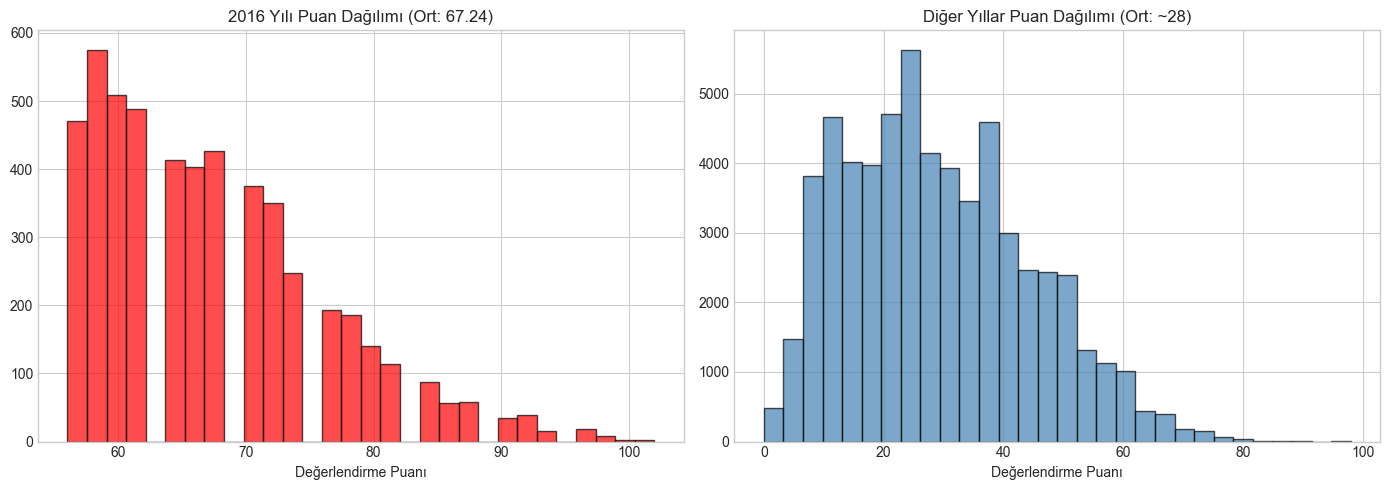


⚠️  SONUÇ: 2016 yılında farklı bir değerlendirme sistemi kullanılmış olabilir!
   Bu durum modelleme sırasında dikkate alınmalı.


In [15]:
# ============================================
# 📌 ADIM 10: 2016 YILI ANOMALİSİ ANALİZİ
# ============================================

print("=" * 60)
print("📌 ADIM 10: 2016 YILI ANOMALİSİ İNCELEMESİ")
print("=" * 60)

# 2016 yılı diğer yıllardan çok farklı ortalamaya sahip (67.24 vs ~30)
df_2016 = train_df[train_df['Basvuru Yili'] == 2016]
df_other = train_df[train_df['Basvuru Yili'] != 2016]

print(f"\n🔹 2016 Yılı Kayıt Sayısı: {len(df_2016):,}")
print(f"🔹 Diğer Yıllar Kayıt Sayısı: {len(df_other):,}")

print(f"\n🔹 2016 Puan Dağılımı:")
print(df_2016['Degerlendirme Puani'].describe())

print(f"\n🔹 Diğer Yıllar Puan Dağılımı:")
print(df_other['Degerlendirme Puani'].describe())

# 2016'nın farklı olmasının sebebini araştır
print("\n🔹 2016 vs Diğer Yıllar - Kategorik Karşılaştırma:")

# Üniversite Türü karşılaştırma
print("\n  Üniversite Türü (2016):")
print(df_2016['Universite Turu'].value_counts(normalize=True).round(3))
print("\n  Üniversite Türü (Diğer):")
print(df_other['Universite Turu'].value_counts(normalize=True).round(3))

# 2016'da farklı bir değerlendirme sistemi mi kullanılmış?
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 2016 puan dağılımı
axes[0].hist(df_2016['Degerlendirme Puani'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='red')
axes[0].set_title('2016 Yılı Puan Dağılımı (Ort: 67.24)')
axes[0].set_xlabel('Değerlendirme Puanı')

# Diğer yıllar puan dağılımı
axes[1].hist(df_other['Degerlendirme Puani'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].set_title('Diğer Yıllar Puan Dağılımı (Ort: ~28)')
axes[1].set_xlabel('Değerlendirme Puanı')

plt.tight_layout()
plt.show()

print("\n⚠️  SONUÇ: 2016 yılında farklı bir değerlendirme sistemi kullanılmış olabilir!")
print("   Bu durum modelleme sırasında dikkate alınmalı.")

In [16]:
# ============================================
# 📌 ADIM 11: İL/İLÇE VERİSİ ANALİZİ
# ============================================

print("=" * 60)
print("📌 ADIM 11: İL/İLÇE VERİSİ ANALİZİ")
print("=" * 60)

# il_ilce veri setini incele
print("\n🔹 il_ilce veri seti boyutu:", il_ilce_df.shape)
print("\n🔹 il_ilce sütunları:")
print(il_ilce_df.columns.tolist())

print("\n🔹 il_ilce örnek veriler:")
print(il_ilce_df.head(10))

# Bu veri nasıl kullanılabilir?
print("\n🔹 İl sayısı:", il_ilce_df['il'].nunique() if 'il' in il_ilce_df.columns else "Sütun bulunamadı")
print("\n🔹 İkametgah Şehri unique değerleri (top 15):")
print(train_df['Ikametgah Sehri'].value_counts().head(15))

📌 ADIM 11: İL/İLÇE VERİSİ ANALİZİ

🔹 il_ilce veri seti boyutu: (973, 2)

🔹 il_ilce sütunları:
['il', 'ilce']

🔹 il_ilce örnek veriler:
      il       ilce
0  Adana     Aladağ
1  Adana     Ceyhan
2  Adana       Feke
3  Adana  Karaisalı
4  Adana    Karataş
5  Adana      Kozan
6  Adana    Pozantı
7  Adana  Saimbeyli
8  Adana    Sarıçam
9  Adana     Seyhan

🔹 İl sayısı: 81

🔹 İkametgah Şehri unique değerleri (top 15):
Ikametgah Sehri
İstanbul      16625
Ankara         6485
Istanbul       3469
İzmir          3096
Bursa          1752
Kocaeli        1453
Antalya        1388
Adana          1320
Konya          1270
Gaziantep      1165
Mersin         1119
Kayseri         983
Eskişehir       928
Diyarbakır      878
Hatay           788
Name: count, dtype: int64


In [17]:
# ============================================
# 📌 ADIM 12: YÜKSEK KARDİNALİTE ANALİZİ
# ============================================

print("=" * 60)
print("📌 ADIM 12: YÜKSEK KARDİNALİTE ANALİZİ")
print("=" * 60)

print("\n🔹 TRAIN - Top 15 Yüksek Kardinalite:")
print(train_df.nunique().sort_values(ascending=False)[:15])

print("\n🔹 TEST - Top 15 Yüksek Kardinalite:")
print(test_df.nunique().sort_values(ascending=False)[:15])

📌 ADIM 12: YÜKSEK KARDİNALİTE ANALİZİ

🔹 TRAIN - Top 15 Yüksek Kardinalite:
id                                                           65125
Lise Adi                                                     31950
Dogum Tarihi                                                 13498
Uye Oldugunuz Kulubun Ismi                                   13423
Hangi STK'nin Uyesisiniz?                                     9490
Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?     9286
Bölüm                                                         7748
Lise Adi Diger                                                4010
Burs Aldigi Baska Kurum                                       3959
Dogum Yeri                                                    2230
Lise Sehir                                                     888
Lise Bolumu                                                    887
Lise Bolum Diger                                               862
Baska Kurumdan Aldigi Burs Miktari                   

In [18]:
# ============================================
# 📌 ADIM 12.1: LİSE ADI YAZIM TUTARSIZLIKLARI
# ============================================

print("=" * 70)
print("🔍 LİSE ADI - YAZIM TUTARSIZLIK ANALİZİ")
print("=" * 70)

# Orijinal vs normalize edilmiş karşılaştırma
lise_original = train_df['Lise Adi'].dropna()
lise_lower = lise_original.str.lower().str.strip()

print(f"\n🔹 Orijinal unique: {lise_original.nunique()}")
print(f"🔹 Lowercase unique: {lise_lower.nunique()}")
print(f"🔹 Potansiyel duplikat: {lise_original.nunique() - lise_lower.nunique()}")

# Örnek tutarsızlıklar bul
print("\n🔹 Aynı lisenin farklı yazımları (örnekler):")

# En sık görülen lise adlarından bazılarını kontrol et
sample_liseler = ['anadolu', 'fen lisesi', 'imam hatip']
for keyword in sample_liseler:
    matches = lise_original[lise_lower.str.contains(keyword, na=False)].value_counts().head(10)
    if len(matches) > 0:
        print(f"\n   '{keyword}' içeren yazımlar ({len(matches)} farklı):")
        for name, count in matches.items():
            print(f"      {count:5d}x | {name}")

🔍 LİSE ADI - YAZIM TUTARSIZLIK ANALİZİ

🔹 Orijinal unique: 31950
🔹 Lowercase unique: 25455
🔹 Potansiyel duplikat: 6495

🔹 Aynı lisenin farklı yazımları (örnekler):

   'anadolu' içeren yazımlar (10 farklı):
        146x | Cumhuriyet Anadolu Lisesi
        138x | Atatürk Anadolu Lisesi
        123x | Ankara Atatürk Anadolu Lisesi
        118x | Fatih Anadolu Lisesi
        110x | Bornova Anadolu Lisesi
         97x | Gazi Anadolu Lisesi
         96x | Kadıköy Anadolu Lisesi
         94x | Anadolu lisesi
         82x | Bahçelievler Anadolu Lisesi
         76x | Cağaloğlu Anadolu Lisesi

   'fen lisesi' içeren yazımlar (10 farklı):
         54x | İzmir Fen Lisesi
         46x | Ankara Fen Lisesi
         36x | Çanakkale Fen Lisesi
         35x | İstanbul Atatürk Fen Lisesi
         34x | Çapa Fen Lisesi
         33x | Manisa Fen Lisesi
         31x | Edirne Süleyman Demirel Fen Lisesi
         28x | Eskişehir Fatih Fen Lisesi
         28x | Aydın Fen Lisesi
         27x | Adana Fen Lisesi

In [19]:
# ============================================
# 📌 ADIM 12.2: STK ÜYELİĞİ YAZIM TUTARSIZLIKLARI
# ============================================

print("=" * 70)
print("🔍 HANGİ STK'NIN ÜYESİSİNİZ? - YAZIM ANALİZİ")
print("=" * 70)

stk_col = "Hangi STK'nin Uyesisiniz?"
stk_original = train_df[stk_col].dropna()
stk_lower = stk_original.str.lower().str.strip()

print(f"\n🔹 Orijinal unique: {stk_original.nunique()}")
print(f"🔹 Lowercase unique: {stk_lower.nunique()}")
print(f"🔹 Potansiyel duplikat: {stk_original.nunique() - stk_lower.nunique()}")

# En sık STK'lar
print("\n🔹 En Sık Görülen STK'lar (Top 20):")
print(stk_original.value_counts().head(20))

# Popüler STK anahtar kelimeleri
print("\n🔹 Popüler STK Anahtar Kelimeleri:")
stk_keywords = ['kızılay', 'kizilay', 'tema', 'toplum', 'gönüllü', 'losev', 'lösev', 'yeşilay']
for keyword in stk_keywords:
    count = stk_lower.str.contains(keyword, na=False).sum()
    unique = stk_original[stk_lower.str.contains(keyword, na=False)].nunique()
    if count > 0:
        print(f"   '{keyword}': {count} kayıt, {unique} farklı yazım")

🔍 HANGİ STK'NIN ÜYESİSİNİZ? - YAZIM ANALİZİ

🔹 Orijinal unique: 9490
🔹 Lowercase unique: 9105
🔹 Potansiyel duplikat: 385

🔹 En Sık Görülen STK'lar (Top 20):
Hangi STK'nin Uyesisiniz?
-                                   2956
Kızılay                              238
Toplum Gönüllüleri Vakfı             196
TEMA                                 181
LÖSEV                                149
Lösev                                132
Tema                                 114
AIESEC                               110
TOG                                   81
Habitat Derneği                       70
Yeşilay                               69
TEGV                                  68
Toplum Gönüllüleri                    58
Tog                                   51
Tema Vakfı                            50
Çağdaş Yaşamı Destekleme Derneği      47
Ahbap                                 42
Greenpeace                            40
lösev                                 35
Toplum gönüllüleri vakfı              

In [20]:
# ============================================
# 📌 ADIM 12.3: KULÜP İSMİ VE DİĞER YÜKSEK KARDİNALİTE
# ============================================

print("=" * 70)
print("🔍 ÜYE OLDUĞUNUZ KULÜBÜN İSMİ - YAZIM ANALİZİ")
print("=" * 70)

kulup_col = "Uye Oldugunuz Kulubun Ismi"
kulup_original = train_df[kulup_col].dropna()
kulup_lower = kulup_original.str.lower().str.strip()

print(f"\n🔹 Orijinal unique: {kulup_original.nunique()}")
print(f"🔹 Lowercase unique: {kulup_lower.nunique()}")
print(f"🔹 Potansiyel duplikat: {kulup_original.nunique() - kulup_lower.nunique()}")

print("\n🔹 En Sık Görülen Kulüpler (Top 15):")
print(kulup_original.value_counts().head(15))

# Özet tablo
print("\n" + "=" * 70)
print("📊 YÜKSEK KARDİNALİTE ÖZETİ - NORMALİZASYON ETKİSİ")
print("=" * 70)

high_card_cols = ['Lise Adi', "Hangi STK'nin Uyesisiniz?", 'Uye Oldugunuz Kulubun Ismi', 'Bölüm', 'Universite Adi']

summary_data = []
for col in high_card_cols:
    original = train_df[col].dropna()
    lower = original.str.lower().str.strip()
    summary_data.append({
        'Sütun': col[:30] + '...' if len(col) > 30 else col,
        'Orijinal': original.nunique(),
        'Normalize': lower.nunique(),
        'Fark': original.nunique() - lower.nunique(),
        'Azalma %': round((original.nunique() - lower.nunique()) / original.nunique() * 100, 1)
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

🔍 ÜYE OLDUĞUNUZ KULÜBÜN İSMİ - YAZIM ANALİZİ

🔹 Orijinal unique: 13423
🔹 Lowercase unique: 12443
🔹 Potansiyel duplikat: 980

🔹 En Sık Görülen Kulüpler (Top 15):
Uye Oldugunuz Kulubun Ismi
IEEE                                               203
Girişimcilik Kulübü                                 60
Kalite ve Verimlilik Kulübü                         43
AIESEC                                              40
İşletme Kulübü                                      39
ODTÜ İşletme Topluluğu                              30
Genç Girişimciler Kulübü                            28
İTÜ Girişimcilik Kulübü                             27
IEEE ODTÜ                                           26
ODTÜ Genç Girişimciler Topluluğu                    26
Endüstri Mühendisliği Kulübü                        25
Boğaziçi Üniversitesi İşletme ve Ekonomi Kulübü     24
ODTÜ Verimlilik Topluluğu                           23
Toplum Gönüllüleri                                  23
Girişimcilik kulübü                       

In [21]:
# ============================================
# 📌 ADIM 13: EDA SONUÇ ÖZETİ
# ============================================

print("=" * 70)
print("📊 KAPSAMLI EDA SONUÇ ÖZETİ")
print("=" * 70)

print("""
🎯 HEDEF DEĞİŞKEN (Degerlendirme Puani):
   • Ortalama: 32.09, Medyan: 29.00, Std: 18.14
   • Aralık: 0-102 puan
   • Sağa çarpık dağılım (right-skewed)
   • Sadece 1 eksik değer, 24 sıfır değer
   • 338 aykırı değer (%0.52)

📅 ZAMAN ANALİZİ:
   • Train: 2014-2022 yılları (9 yıl)
   • Test: SADECE 2023 yılı (train'de yok!)
   ⚠️  2016 yılı çok farklı (ort: 67.24 vs diğer yıllar: ~28)
       - Min değer bile 56 (diğer yıllarda 0)
       - Farklı değerlendirme sistemi kullanılmış olabilir

🔢 VERİ BOYUTU:
   • Train: 65,125 satır × 44 sütun
   • Test: 11,049 satır × 43 sütun
   • 4 sayısal, 40 kategorik sütun

📊 YÜKSEK KARDİNALİTE SORUNLARI:
   Sütun                          Orijinal  Normalize  Azalma%
   ─────────────────────────────────────────────────────────────
   Lise Adi                        31,950    25,455    20.3%
   Bölüm                            7,748     6,411    17.3%
   Kulüp İsmi                      13,423    12,443     7.3%
   STK Üyeliği                      9,490     9,105     4.1%
   
   ⚠️ Sadece lowercase yaparak binlerce duplikat azaltılabilir!
   ⚠️ STK'da "-" değeri 2,956 kez var (boş anlamında)
   ⚠️ Kızılay: 836 farklı yazım, TEMA: 918 farklı yazım!

❌ EKSİK DEĞERLER:
   • Train'de birçok sütunda yüksek oranda eksik değer
   • Test'te bazı sütunlar %100 eksik (Burslu ise Burs Yuzdesi, vb.)
   • Lise Adi Diger, Lise Bolum Diger %97+ eksik

⚠️  TEMİZLENMESİ GEREKEN VERİ KALİTESİ SORUNLARI:
   1. Büyük/küçük harf tutarsızlıkları:
      - Cinsiyet: Erkek/ERKEK
      - Universite Turu: Devlet/DEVLET, Özel/ÖZEL
      - Burs Aliyor mu: Evet/EVET/evet, Hayır/hayır
      - Anne/Baba Egitim: İlkokul/İLKOKUL, Lise/LİSE
   2. Format tutarsızlıkları:
      - Universite Not Ortalamasi: 20 farklı format
      - Lise Mezuniyet Notu: 19 farklı format
      - Dogum Tarihi: 13,498 unique değer (farklı formatlar)
   3. Şehir yazımları: Istanbul/İstanbul
   4. Yüksek kardinaliteli metin sütunları (Lise, STK, Kulüp, Bölüm)

🔥 EN ETKİLİ FAKTÖRLER (Hedef ile İlişki):
   1. Girişimcilik kulübü: Evet=43.86 vs Hayır=22.44 (+21.4 puan!)
   2. STK üyeliği: Evet=47.41 vs Hayır=27.91 (+19.5 puan!)
   3. Girişimcilik deneyimi: Evet=42.61 vs Hayır=28.29 (+14.3 puan)
   4. Spor aktivitesi: Evet=40.96 vs Hayır=27.79 (+13.2 puan)
   5. İngilizce bilgisi: Evet=34.10 vs Hayır=22.92 (+11.2 puan)
   6. Üniversite türü: Özel=40.24 vs Devlet=33.73 (+6.5 puan)

📈 SONRAKİ ADIMLAR (Feature Engineering):
   1. Metin normalizasyonu (lowercase, strip, Türkçe karakter)
   2. STK/Kulüp için anahtar kelime çıkarımı (tema, kızılay, ieee vb.)
   3. "-" ve boş değerleri "Yok" olarak işaretleme
   4. Lise türü çıkarımı (Fen, Anadolu, İmam Hatip vb.)
   5. Yaş hesaplama (Doğum Tarihi'nden)
   6. Target Encoding / Frequency Encoding
   7. Model geliştirme (CatBoost, LightGBM, XGBoost)
""")

print("=" * 70)
print("✅ EDA TAMAMLANDI - VERİ TEMİZLEME VE FE AŞAMASINA GEÇEBİLİRİZ")
print("=" * 70)

📊 KAPSAMLI EDA SONUÇ ÖZETİ

🎯 HEDEF DEĞİŞKEN (Degerlendirme Puani):
   • Ortalama: 32.09, Medyan: 29.00, Std: 18.14
   • Aralık: 0-102 puan
   • Sağa çarpık dağılım (right-skewed)
   • Sadece 1 eksik değer, 24 sıfır değer
   • 338 aykırı değer (%0.52)

📅 ZAMAN ANALİZİ:
   • Train: 2014-2022 yılları (9 yıl)
   • Test: SADECE 2023 yılı (train'de yok!)
   ⚠️  2016 yılı çok farklı (ort: 67.24 vs diğer yıllar: ~28)
       - Min değer bile 56 (diğer yıllarda 0)
       - Farklı değerlendirme sistemi kullanılmış olabilir

🔢 VERİ BOYUTU:
   • Train: 65,125 satır × 44 sütun
   • Test: 11,049 satır × 43 sütun
   • 4 sayısal, 40 kategorik sütun

📊 YÜKSEK KARDİNALİTE SORUNLARI:
   Sütun                          Orijinal  Normalize  Azalma%
   ─────────────────────────────────────────────────────────────
   Lise Adi                        31,950    25,455    20.3%
   Bölüm                            7,748     6,411    17.3%
   Kulüp İsmi                      13,423    12,443     7.3%
   STK Üyeliği 

In [3]:
# ============================================
# 📌 ADIM 14: VERİ TEMİZLEME VE FEATURE ENGINEERING (Hızlandırılmış)
# ============================================

import re
import unicodedata
from datetime import datetime
from rapidfuzz import process, fuzz

print("=" * 60)
print("📌 ADIM 14: VERİ TEMİZLEME + FE BAŞLANGIÇ (FAST)")
print("=" * 60)

# Hız ayarları
USE_FUZZY = False           # Varsayılan: hız için kapalı. Açmak istersen True yap.
FUZZY_TOP_K = 800           # En sık görülen kaç değere yakınsın
FUZZY_SCORE_CUTOFF = 92     # Eşik (daha yüksek -> daha katı)
FUZZY_RARE_ONLY = True      # Sadece nadir değerler için fuzzy uygula
FUZZY_MIN_FREQ = 5          # Frekansı <= min_freq olan değerlere fuzzy uygula

# Türkçe karakterleri ASCII'ye indirgeme haritası
TRANSLIT_MAP = str.maketrans({
    'ç': 'c', 'ğ': 'g', 'ı': 'i', 'ö': 'o', 'ş': 's', 'ü': 'u',
    'â': 'a', 'î': 'i', 'û': 'u'
})

# Yardımcı: metin normalize (lower + strip, opsiyonel accent/punct temizliği)
def normalize_text(s: pd.Series, strip_accents: bool = False, strip_symbols: bool = False):
    s_norm = s.fillna("").str.lower()
    if strip_accents:
        s_norm = s_norm.apply(lambda x: ''.join(
            ch for ch in unicodedata.normalize('NFKD', x)
            if not unicodedata.combining(ch)
        ))
        s_norm = s_norm.str.translate(TRANSLIT_MAP)
    if strip_symbols:
        s_norm = s_norm.str.replace(r"[^a-z0-9çğıöşü ]+", " ", regex=True)
    s_norm = s_norm.str.replace(r"\s+", " ", regex=True).str.strip()
    return s_norm

# Yardımcı: evet/hayır standardizasyonu
def normalize_yes_no(s: pd.Series):
    s_norm = normalize_text(s)
    mapper = {
        'evet': 'Evet', 'e': 'Evet',
        'hayir': 'Hayır', 'hayır': 'Hayır', 'h': 'Hayır',
        '': np.nan, '-': np.nan
    }
    return s_norm.replace(mapper)

# Yardımcı: kategori normalize (lower/strip, boşları NaN yap)
def normalize_cat(s: pd.Series):
    s_norm = normalize_text(s)
    s_norm = s_norm.replace({'-': np.nan, 'yok': np.nan, '': np.nan})
    return s_norm

# Yardımcı: okul/dernek/kulüp isimleri için agresif normalize (accent ve sembol temizler)
def normalize_name_like(s: pd.Series):
    s_norm = normalize_text(s, strip_accents=True, strip_symbols=True)
    s_norm = s_norm.str.translate(TRANSLIT_MAP)
    s_norm = s_norm.replace({'-': np.nan, 'yok': np.nan, '': np.nan})
    return s_norm

# Yardımcı: fuzzy eşleştirmeyi hızlı ve nadir değere odaklı yap
def fuzzy_standardize(train: pd.DataFrame, test: pd.DataFrame, col: str,
                      top_k: int = FUZZY_TOP_K,
                      score_cutoff: int = FUZZY_SCORE_CUTOFF,
                      rare_only: bool = FUZZY_RARE_ONLY,
                      min_freq: int = FUZZY_MIN_FREQ):
    if col not in train:
        return train, test

    # Anchor set: en sık top_k değerler
    vc = train[col].dropna().value_counts()
    top_vals = vc.head(top_k).index.tolist()
    if not top_vals:
        return train, test

    # Aday küme: yalnızca nadir ve top listede olmayan unique değerler
    uniques = train[col].dropna().unique().tolist()
    if rare_only:
        candidates = [u for u in uniques if (vc.get(u, 0) <= min_freq and u not in top_vals)]
    else:
        candidates = [u for u in uniques if u not in top_vals]

    # Önceden bilinenleri kendine map'le
    mapping = {v: v for v in top_vals}

    # RapidFuzz: her candidate için bir kez en iyi eşi bulunur
    for val in candidates:
        best = process.extractOne(val, top_vals, scorer=fuzz.token_set_ratio, score_cutoff=score_cutoff)
        if best:
            mapping[val] = best[0]
        else:
            mapping[val] = val

    # Uygula (map cache sayesinde tekrarlı hesap yok)
    train[col] = train[col].map(lambda x: mapping.get(x, x))
    if col in test:
        test[col] = test[col].map(lambda x: mapping.get(x, x))
    return train, test

# Yardımcı: ordinal encoding (sıralı kategorileri sayıya çevir) - düşük seviyeden yükseğe doğru
def ordinal_encode(df: pd.DataFrame, mapping: dict):
    for col, order in mapping.items():
        if col in df:
            mapper = {k: i for i, k in enumerate(order)}
            df[col] = df[col].map(mapper)
    return df

# Yardımcı: frekans encoding
def frequency_encode(train: pd.DataFrame, test: pd.DataFrame, cols):
    for col in cols:
        freq = train[col].value_counts(dropna=False) / len(train)
        train[f"{col}_freq"] = train[col].map(freq)
        test[f"{col}_freq"] = test[col].map(freq)
    return train, test

# Tarih -> yaş (Basvuru Yili - doğum yılı)
def add_age_features(df):
    dob = pd.to_datetime(df['Dogum Tarihi'], errors='coerce', dayfirst=True)
    df['Dogum_Yili'] = dob.dt.year
    df['Yas'] = df['Basvuru Yili'] - df['Dogum_Yili']
    return df

# Temizlik + FE pipeline

def clean_and_fe(train_df, test_df):
    train = train_df.copy()
    test = test_df.copy()

    # Ortak kolonlar temizleme (isim benzeri alanlar için agresif normalize + translit)
    name_like_cols = [
        'Lise Adi', "Hangi STK'nin Uyesisiniz?", 'Uye Oldugunuz Kulubun Ismi',
        'Bölüm', 'Universite Adi'
    ]
    for col in name_like_cols:
        if col in train:
            train[col] = normalize_name_like(train[col])
        if col in test:
            test[col] = normalize_name_like(test[col])

    # Fuzzy ile sık isimlere map (yüksek kardinaliteyi azalt) — hız için opsiyonel
    if USE_FUZZY:
        for col in ['Lise Adi', "Hangi STK'nin Uyesisiniz?", 'Uye Oldugunuz Kulubun Ismi', 'Universite Adi']:
            train, test = fuzzy_standardize(train, test, col)

    # Daha hafif normalize gereken kolonlar
    for col in ['Dogum Yeri', 'Ikametgah Sehri', 'Lise Sehir']:
        if col in train:
            train[col] = normalize_cat(train[col])
        if col in test:
            test[col] = normalize_cat(test[col])

    # Evet/Hayır kolonları normalize
    yn_cols = [
        'Burs Aliyor mu?', 'Baska Bir Kurumdan Burs Aliyor mu?',
        'Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?',
        'Profesyonel Bir Spor Daliyla Mesgul musunuz?',
        'Aktif olarak bir STK üyesi misiniz?',
        'Girisimcilikle Ilgili Deneyiminiz Var Mi?',
        'Ingilizce Biliyor musunuz?'
    ]
    for col in yn_cols:
        if col in train:
            train[col] = normalize_yes_no(train[col])
        if col in test:
            test[col] = normalize_yes_no(test[col])

    # Cinsiyet standardizasyonu
    if 'Cinsiyet' in train:
        gender_map = {
            'erkek': 'Erkek', 'erke': 'Erkek', 'e': 'Erkek', 'erk': 'Erkek',
            'kadın': 'Kadın', 'kadin': 'Kadın', 'k': 'Kadın',
            'belirtmek istemiyorum': 'Belirtmek istemiyorum'
        }
        train['Cinsiyet'] = normalize_text(train['Cinsiyet']).replace(gender_map)
        test['Cinsiyet'] = normalize_text(test['Cinsiyet']).replace(gender_map)

    # Üniversite Türü standardizasyonu
    if 'Universite Turu' in train:
        uni_map = {'devlet': 'Devlet', 'özel': 'Özel', 'ozel': 'Özel'}
        train['Universite Turu'] = normalize_text(train['Universite Turu']).replace(uni_map)
        test['Universite Turu'] = normalize_text(test['Universite Turu']).replace(uni_map)

    # Ordinal encoding (detaylı sıralı listeler, düşük seviye -> yüksek seviye)
    ordinal_mapping = {
        'Universite Kacinci Sinif': ['hazirlik', 'hazirlik sinif', 'hazirlik ve 1', '1', '2', '3', '4', '5', '6', 'mezun'],
        'Anne Egitim Durumu': ['okur yazar degil', 'ilkokul', 'ortaokul', 'lise', 'on lisans', 'lisans', 'yuksek lisans', 'doktora'],
        'Baba Egitim Durumu': ['okur yazar degil', 'ilkokul', 'ortaokul', 'lise', 'on lisans', 'lisans', 'yuksek lisans', 'doktora'],
        'Universite Not Ortalamasi': ['0-1.00', '1.01-1.50', '1.51-2.00', '2.01-2.50', '2.51-3.00', '3.01-3.50', '3.51-4.00'],
        'Lise Mezuniyet Notu': ['0 - 49', '50 - 59', '60 - 69', '70 - 79', '80 - 89', '90 - 100']
    }
    train = ordinal_encode(train, ordinal_mapping)
    test = ordinal_encode(test, ordinal_mapping)

    # Yaş feature
    train = add_age_features(train)
    test = add_age_features(test)

    # Frekans encoding (yüksek kardinalite)
    high_card_cols = ['Lise Adi', 'Bölüm', "Hangi STK'nin Uyesisiniz?", 'Uye Oldugunuz Kulubun Ismi', 'Universite Adi']
    train, test = frequency_encode(train, test, [c for c in high_card_cols if c in train])

    return train, test

# Pipeline'ı çalıştır
clean_train_df, clean_test_df = clean_and_fe(train_df, test_df)

print("Temizleme + FE tamamlandı. Kolon sayısı:", clean_train_df.shape[1], clean_test_df.shape[1])

📌 ADIM 14: VERİ TEMİZLEME + FE BAŞLANGIÇ (FAST)


C:\Users\MONSTER\AppData\Local\Temp\ipykernel_20716\105308579.py:61: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  s_norm = s_norm.replace({'-': np.nan, 'yok': np.nan, '': np.nan})


Temizleme + FE tamamlandı. Kolon sayısı: 51 50


In [7]:
# ============================================
# 📌 ADIM 15: HIZLI MODELLEME (CatBoost)
# ============================================

print("=" * 60)
print("📌 ADIM 15: CATBOOST MODELLEME + SUBMISSION")
print("=" * 60)

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor, Pool

# Temiz veri: ADIM 14'te üretilen clean_train_df / clean_test_df kullanılacak
assert 'clean_train_df' in globals() and 'clean_test_df' in globals(), "Önce ADIM 14'ü çalıştırın."

target_col = 'Degerlendirme Puani'
# Ortak feature set (test'te olanlar); hedef ve id'yi çıkar
common_cols = sorted(list(set(clean_train_df.columns) & set(clean_test_df.columns)))
drop_candidates = ['id']
feature_cols = [c for c in common_cols if c not in drop_candidates]

X = clean_train_df[feature_cols].copy()
y = clean_train_df[target_col].copy()
X_test = clean_test_df[feature_cols].copy()

# Hedefteki NaN'leri düş
mask = y.notna()
X = X[mask]
y = y[mask]

# Kategorik sütun indexleri (CatBoost için)
cat_features = [i for i, c in enumerate(feature_cols) if X[c].dtype == 'object']
print(f"🔹 Feature sayısı: {len(feature_cols)} | Kategorik: {len(cat_features)}")

# CatBoost categorical: NaN/textler string olmalı
if len(cat_features) > 0:
    cat_cols = [feature_cols[i] for i in cat_features]
    for c in cat_cols:
        X[c] = X[c].fillna('__nan__').astype(str)
        X_test[c] = X_test[c].fillna('__nan__').astype(str)

# 5-Fold CV ile hızlı değerlendirme
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

params = {
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'depth': 8,
    'learning_rate': 0.06,
    'iterations': 800,
    'l2_leaf_reg': 3.0,
    'random_state': 42,
    'verbose': 200,
    'allow_const_label': True,
}

fold_idx = 1
for tr_idx, val_idx in kf.split(X):
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    train_pool = Pool(X_tr, y_tr, cat_features=cat_features)
    val_pool = Pool(X_val, y_val, cat_features=cat_features)

    model = CatBoostRegressor(**params)
    model.fit(train_pool, eval_set=val_pool, use_best_model=True, early_stopping_rounds=100)

    val_pred = model.predict(val_pool)
    rmse = float(np.sqrt(((y_val - val_pred) ** 2).mean()))
    cv_scores.append(rmse)
    print(f"Fold {fold_idx} RMSE: {rmse:.4f}")
    fold_idx += 1

print(f"\n🔹 CV RMSE (mean ± std): {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Final modeli tüm veri ile eğit (küçük bir eval split kullanarak erken durdurma)
val_frac = 0.1
val_size = max(1, int(len(X) * val_frac))
X_train_final = X.iloc[:-val_size]
y_train_final = y.iloc[:-val_size]
X_val_final = X.iloc[-val_size:]
y_val_final = y.iloc[-val_size:]

train_pool_final = Pool(X_train_final, y_train_final, cat_features=cat_features)
val_pool_final = Pool(X_val_final, y_val_final, cat_features=cat_features)

final_model = CatBoostRegressor(**params)
final_model.fit(train_pool_final, eval_set=val_pool_final, use_best_model=True, early_stopping_rounds=100)

# Test tahmini
test_pool = Pool(X_test, cat_features=cat_features)
test_pred = final_model.predict(test_pool)

# Submission dosyası oluştur
assert 'test_df' in globals(), "test_df yüklenemedi (Cell 1)."
assert 'sample_sub_df' in globals() and sample_sub_df is not None, "sample_submission.csv bulunamadı."
id_col = 'id' if 'id' in test_df.columns else test_df.columns[0]
submission = pd.DataFrame({id_col: test_df[id_col], target_col: test_pred})
out_path = Path('data') / 'submission_catboost.csv'
submission.to_csv(out_path, index=False)

print(f"\n✅ Submission hazır: {str(out_path)}")
print("Örnek:")
print(submission.head(5))

📌 ADIM 15: CATBOOST MODELLEME + SUBMISSION
🔹 Feature sayısı: 49 | Kategorik: 35
0:	learn: 17.2665931	test: 17.3155321	best: 17.3155321 (0)	total: 231ms	remaining: 3m 4s
200:	learn: 5.8716005	test: 5.9736514	best: 5.9736514 (200)	total: 50.1s	remaining: 2m 29s
400:	learn: 5.6367805	test: 5.9000215	best: 5.9000215 (400)	total: 1m 44s	remaining: 1m 44s
600:	learn: 5.4925311	test: 5.8747368	best: 5.8745338 (597)	total: 2m 46s	remaining: 55.3s
799:	learn: 5.3671279	test: 5.8618272	best: 5.8618272 (799)	total: 3m 55s	remaining: 0us

bestTest = 5.861827151
bestIteration = 799

Fold 1 RMSE: 5.8623
0:	learn: 17.2844845	test: 17.1716826	best: 17.1716826 (0)	total: 260ms	remaining: 3m 28s
200:	learn: 5.8892031	test: 5.9817474	best: 5.9817474 (200)	total: 56.9s	remaining: 2m 49s
400:	learn: 5.6807831	test: 5.9070480	best: 5.9070476 (399)	total: 1m 55s	remaining: 1m 54s
600:	learn: 5.5305268	test: 5.8793518	best: 5.8793050 (599)	total: 2m 56s	remaining: 58.5s
799:	learn: 5.3945997	test: 5.8680871	b

In [8]:
# Hızlı Deney: 2016 çıkarılmış 3-fold hızlı CatBoost CV
import time
import numpy as np
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor, Pool

start = time.time()
print('Başlatılıyor...')

# Varsayılan ADIM14 değişkenleri kullanılacak
if 'clean_train_df' not in globals() or 'feature_cols' not in globals():
    raise RuntimeError("clean_train_df veya feature_cols bulunamadı. Önce ADIM 14 ve ADIM 15'i çalıştırın.")

df = clean_train_df.copy()
cols = feature_cols.copy()
target = 'Degerlendirme Puani'

mask = df[target].notna() & (df['Basvuru Yili'] != 2016)
X = df.loc[mask, cols].copy()
y = df.loc[mask, target].copy()
print(f"Veri boyutu (2016 çıkarıldı): {X.shape[0]} satır")

# kategorik indexleri yeniden hesapla
cat_features = [i for i, c in enumerate(cols) if X[c].dtype == 'object']
cat_cols = [cols[i] for i in cat_features]
for c in cat_cols:
    X[c] = X[c].fillna('__nan__').astype(str)

kf = KFold(n_splits=3, shuffle=True, random_state=42)
params_fast = {
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'depth': 6,
    'learning_rate': 0.08,
    'iterations': 300,
    'random_state': 42,
    'verbose': 100,
}

cv_scores = []
for fold, (tr_idx, val_idx) in enumerate(kf.split(X), 1):
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
    train_pool = Pool(X_tr, y_tr, cat_features=cat_features)
    val_pool = Pool(X_val, y_val, cat_features=cat_features)
    m = CatBoostRegressor(**params_fast)
    m.fit(train_pool, eval_set=val_pool, use_best_model=True, early_stopping_rounds=50)
    pred = m.predict(val_pool)
    rmse = float(np.sqrt(((y_val - pred) ** 2).mean()))
    print(f"Fold {fold} RMSE: {rmse:.4f}")
    cv_scores.append(rmse)

print(f"Hızlı CV RMSE (mean ± std): {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
print(f"Geçen süre: {time.time()-start:.1f} s")
print('Referans (tam run): 5.8747')


Başlatılıyor...
Veri boyutu (2016 çıkarıldı): 59911 satır
0:	learn: 14.4390568	test: 14.4592915	best: 14.4592915 (0)	total: 158ms	remaining: 47.2s
100:	learn: 6.3526498	test: 6.3531170	best: 6.3531170 (100)	total: 16.2s	remaining: 31.9s
200:	learn: 6.1315814	test: 6.1918310	best: 6.1918310 (200)	total: 34.5s	remaining: 17s
299:	learn: 6.0434390	test: 6.1528365	best: 6.1528365 (299)	total: 52.9s	remaining: 0us

bestTest = 6.152836524
bestIteration = 299

Fold 1 RMSE: 6.1534
0:	learn: 14.4165859	test: 14.4427555	best: 14.4427555 (0)	total: 191ms	remaining: 57s
100:	learn: 6.3087298	test: 6.3259567	best: 6.3259567 (100)	total: 16.5s	remaining: 32.5s
200:	learn: 6.1393229	test: 6.1994140	best: 6.1994140 (200)	total: 32.9s	remaining: 16.2s
299:	learn: 6.0519771	test: 6.1585634	best: 6.1585634 (299)	total: 49.8s	remaining: 0us

bestTest = 6.158563435
bestIteration = 299

Fold 2 RMSE: 6.1586
0:	learn: 14.4651052	test: 14.4221279	best: 14.4221279 (0)	total: 149ms	remaining: 44.5s
100:	learn: 6

In [9]:
# Deney: is_2016 bayrağı ile hızlı CatBoost CV
import time
import numpy as np
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor, Pool

start = time.time()
print('Başlatılıyor (is_2016 deneyi)...')

if 'clean_train_df' not in globals() or 'feature_cols' not in globals():
    raise RuntimeError("clean_train_df veya feature_cols bulunamadı. Önce ADIM 14 ve ADIM 15'i çalıştırın.")

df = clean_train_df.copy()
cols = feature_cols.copy()
target = 'Degerlendirme Puani'

# is_2016 bayrağı ekle
df['is_2016'] = (df['Basvuru Yili'] == 2016).astype(int)
cols2 = cols + ['is_2016'] if 'is_2016' not in cols else cols

# Hedef NaN'leri çıkar
mask = df[target].notna()
X = df.loc[mask, cols2].copy()
y = df.loc[mask, target].copy()
print(f"Veri boyutu (tüm yıllar, is_2016 var): {X.shape[0]} satır, {X.shape[1]} sütun")

# kategorik indexleri hesapla
cat_features = [i for i, c in enumerate(cols2) if X[c].dtype == 'object']
cat_cols = [cols2[i] for i in cat_features]
for c in cat_cols:
    X[c] = X[c].fillna('__nan__').astype(str)

kf = KFold(n_splits=3, shuffle=True, random_state=42)
params_fast = {
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'depth': 6,
    'learning_rate': 0.08,
    'iterations': 300,
    'random_state': 42,
    'verbose': 100,
}

cv_scores = []
for fold, (tr_idx, val_idx) in enumerate(kf.split(X), 1):
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
    train_pool = Pool(X_tr, y_tr, cat_features=cat_features)
    val_pool = Pool(X_val, y_val, cat_features=cat_features)
    m = CatBoostRegressor(**params_fast)
    m.fit(train_pool, eval_set=val_pool, use_best_model=True, early_stopping_rounds=50)
    pred = m.predict(val_pool)
    rmse = float(np.sqrt(((y_val - pred) ** 2).mean()))
    print(f"Fold {fold} RMSE: {rmse:.4f}")
    cv_scores.append(rmse)

print(f"Hızlı CV RMSE (mean ± std) with is_2016: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
print(f"Geçen süre: {time.time()-start:.1f} s")
print('Referans (tam run): 5.8747, Drop2016 hızlı run: 6.1446')


Başlatılıyor (is_2016 deneyi)...
Veri boyutu (tüm yıllar, is_2016 var): 65124 satır, 50 sütun
0:	learn: 17.0139420	test: 17.0309195	best: 17.0309195 (0)	total: 138ms	remaining: 41.4s
100:	learn: 6.1961670	test: 6.1491395	best: 6.1491395 (100)	total: 17.2s	remaining: 33.9s
200:	learn: 5.9541655	test: 5.9796102	best: 5.9796102 (200)	total: 34.6s	remaining: 17s
299:	learn: 5.8649263	test: 5.9384432	best: 5.9384432 (299)	total: 52s	remaining: 0us

bestTest = 5.938443211
bestIteration = 299

Fold 1 RMSE: 5.9388
0:	learn: 17.0567336	test: 16.9375359	best: 16.9375359 (0)	total: 161ms	remaining: 48.3s
100:	learn: 6.1903977	test: 6.1591968	best: 6.1591968 (100)	total: 16.9s	remaining: 33.2s
200:	learn: 5.9716963	test: 5.9861559	best: 5.9861559 (200)	total: 34s	remaining: 16.8s
299:	learn: 5.8767321	test: 5.9376339	best: 5.9372056 (295)	total: 51.1s	remaining: 0us

bestTest = 5.937205563
bestIteration = 295

Shrink model to first 296 iterations.
Fold 2 RMSE: 5.9375
0:	learn: 16.9847974	test: 17.

In [10]:
# TAM RUN: is_2016 ile 5-fold CatBoost (iterations=800)
import time
import numpy as np
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor, Pool
from pathlib import Path

start = time.time()
print('Tam run basliyor — bu ~20 dakika alabilir...')

# Gereken veriler
assert 'clean_train_df' in globals() and 'clean_test_df' in globals(), "Önce ADIM 14 çalıştırın (clean_train_df, clean_test_df)."

df = clean_train_df.copy()
test_df_local = clean_test_df.copy()
cols = feature_cols.copy()
target = 'Degerlendirme Puani'

# is_2016 bayrağı
df['is_2016'] = (df['Basvuru Yili'] == 2016).astype(int)
# test tarafı çoğunlukla 2023 olacak; yine de ekle
test_df_local['is_2016'] = (test_df_local.get('Basvuru Yili', 0) == 2016).astype(int)
if 'is_2016' not in cols:
    cols = cols + ['is_2016']

# Drop NaN hedef
mask = df[target].notna()
X = df.loc[mask, cols].copy()
y = df.loc[mask, target].copy()
X_test = test_df_local[cols].copy()

print(f"Egitim veri boyutu: {X.shape[0]} satir, {X.shape[1]} features")

# Kategorik indeksleri ve dolgu
cat_features = [i for i, c in enumerate(cols) if X[c].dtype == 'object']
cat_cols = [cols[i] for i in cat_features]
for c in cat_cols:
    X[c] = X[c].fillna('__nan__').astype(str)
    X_test[c] = X_test[c].fillna('__nan__').astype(str)

# 5-fold, tam param
kf = KFold(n_splits=5, shuffle=True, random_state=42)
params = {
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'depth': 8,
    'learning_rate': 0.06,
    'iterations': 800,
    'l2_leaf_reg': 3.0,
    'random_state': 42,
    'verbose': 200,
    'allow_const_label': True,
}

cv_scores = []
fold = 1
for tr_idx, val_idx in kf.split(X):
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
    train_pool = Pool(X_tr, y_tr, cat_features=cat_features)
    val_pool = Pool(X_val, y_val, cat_features=cat_features)

    model = CatBoostRegressor(**params)
    model.fit(train_pool, eval_set=val_pool, use_best_model=True, early_stopping_rounds=100)

    val_pred = model.predict(val_pool)
    rmse = float(np.sqrt(((y_val - val_pred) ** 2).mean()))
    print(f"Fold {fold} RMSE: {rmse:.4f}")
    cv_scores.append(rmse)
    fold += 1

print(f"\nCV RMSE (mean ± std): {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Final model: train on all (küçük val split for early stop)
val_frac = 0.1
val_size = max(1, int(len(X) * val_frac))
X_train_final = X.iloc[:-val_size]
y_train_final = y.iloc[:-val_size]
X_val_final = X.iloc[-val_size:]
y_val_final = y.iloc[-val_size:]

train_pool_final = Pool(X_train_final, y_train_final, cat_features=cat_features)
val_pool_final = Pool(X_val_final, y_val_final, cat_features=cat_features)

final_model = CatBoostRegressor(**params)
final_model.fit(train_pool_final, eval_set=val_pool_final, use_best_model=True, early_stopping_rounds=100)

# Test tahmini ve submission
test_pool = Pool(X_test, cat_features=cat_features)
test_pred = final_model.predict(test_pool)

# Yazdır
id_col = 'id' if 'id' in test_df.columns else test_df.columns[0]
submission = pd.DataFrame({id_col: test_df[id_col], target: test_pred})
out_path = Path('data') / 'submission_catboost_is2016_full.csv'
submission.to_csv(out_path, index=False)

print(f"\n✅ Tam run tamamlandı. CV RMSE: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
print(f"Submission: {out_path}")
print(f"Toplam geçen süre: {time.time() - start:.1f} s")


Tam run basliyor — bu ~20 dakika alabilir...
Egitim veri boyutu: 65124 satir, 50 features
0:	learn: 17.2493056	test: 17.2982234	best: 17.2982234 (0)	total: 268ms	remaining: 3m 34s
200:	learn: 5.8493732	test: 5.9415258	best: 5.9415258 (200)	total: 56.9s	remaining: 2m 49s
400:	learn: 5.6348249	test: 5.8704754	best: 5.8704754 (400)	total: 1m 59s	remaining: 1m 59s
600:	learn: 5.4810671	test: 5.8488225	best: 5.8487986 (599)	total: 3m 4s	remaining: 1m 1s
799:	learn: 5.3554153	test: 5.8418742	best: 5.8416559 (794)	total: 4m 11s	remaining: 0us

bestTest = 5.841655938
bestIteration = 794

Shrink model to first 795 iterations.
Fold 1 RMSE: 5.8417
0:	learn: 17.2803213	test: 17.1691135	best: 17.1691135 (0)	total: 302ms	remaining: 4m 1s
200:	learn: 5.8699303	test: 5.9672783	best: 5.9672783 (200)	total: 58s	remaining: 2m 52s
400:	learn: 5.6566408	test: 5.8974296	best: 5.8967329 (398)	total: 2m 1s	remaining: 2m
600:	learn: 5.5109432	test: 5.8729444	best: 5.8729444 (600)	total: 3m 13s	remaining: 1m 3s

In [11]:
# Feature importance (final_model) - top 20 ve kaydet
import pandas as pd
import numpy as np
from pathlib import Path

assert 'final_model' in globals(), "final_model yok. Tam run'ı çalıştırın önce."
# feature isimleri: tercih feature_cols, cols veya X.columns
if 'cols' in globals():
    feat_names = cols
elif 'feature_cols' in globals():
    feat_names = feature_cols
elif 'X' in globals():
    feat_names = list(X.columns)
else:
    raise RuntimeError('Feature isimleri bulunamadı (cols/feature_cols/X).')

# CatBoost feature importance
try:
    imp_vals = final_model.get_feature_importance()
except Exception:
    imp_vals = final_model.get_feature_importance(Pool(X_train_final, y_train_final, cat_features=cat_features))

fi = pd.DataFrame({'feature': feat_names, 'importance': imp_vals})
fi = fi.sort_values('importance', ascending=False).reset_index(drop=True)
print('Top 20 feature importance:')
print(fi.head(20).to_string(index=False))

out = Path('data') / 'feature_importances_is2016.csv'
fi.to_csv(out, index=False)
print(f"Feature importance saved: {out}")


Top 20 feature importance:
                                              feature  importance
 Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?   30.173223
                                              is_2016   24.535767
         Profesyonel Bir Spor Daliyla Mesgul musunuz?   13.128711
                  Aktif olarak bir STK üyesi misiniz?    9.053056
                         Stk Projesine Katildiniz Mi?    8.833750
                        Spor Dalindaki Rolunuz Nedir?    5.049071
            Girisimcilikle Ilgili Deneyiminiz Var Mi?    4.466251
                                             Cinsiyet    1.316849
                           Ingilizce Biliyor musunuz?    1.080369
                                          Anne Sektor    0.992867
                                            Lise Turu    0.731687
        Daha Once Baska Bir Universiteden Mezun Olmus    0.638399
                                  Anne Calisma Durumu    0.000000
                                   Anne Egitim Du

In [12]:
# İnceleme: il_ilce.csv içeriğine göz at
import pandas as pd
from pathlib import Path
p = Path('data') / 'il_ilce.csv'
if not p.exists():
    print('data/il_ilce.csv bulunamadı')
else:
    ildf = pd.read_csv(p)
    print('shape:', ildf.shape)
    print('columns:', list(ildf.columns))
    display(ildf.head(10))
    print('\nUnique il sayısı (ilk sütunlardan tahmine göre):')
    # tahmini il sütunu isimleri
    for candidate in ['il','Il','İl','sehir','sehır','sehir_adi','sehiradi']:
        if candidate in ildf.columns:
            print(candidate, '->', ildf[candidate].nunique())
    
    # show sample rows where il/ilce present
    for c in ildf.columns[:5]:
        try:
            print('\nSample values for', c, '->', ildf[c].dropna().unique()[:5])
        except Exception:
            pass


shape: (973, 2)
columns: ['il', 'ilce']


,il,ilce
0,Adana,Aladağ
1,Adana,Ceyhan
2,Adana,Feke
3,Adana,Karaisalı
4,Adana,Karataş
5,Adana,Kozan
6,Adana,Pozantı
7,Adana,Saimbeyli
8,Adana,Sarıçam
9,Adana,Seyhan



Unique il sayısı (ilk sütunlardan tahmine göre):
il -> 81

Sample values for il -> ['Adana' 'Adıyaman' 'Afyonkarahisar' 'Aksaray' 'Amasya']

Sample values for ilce -> ['Aladağ' 'Ceyhan' 'Feke' 'Karaisalı' 'Karataş']


In [16]:
# Merge ve hızlı test: il-level mean + freq ekle ve 3-fold hız testi
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor, Pool

start = time.time()
# require clean_train_df and clean_test_df
assert 'clean_train_df' in globals() and 'clean_test_df' in globals(), "Önce ADIM 14'ü çalıştırın."

train = clean_train_df.copy()
test = clean_test_df.copy()

# load il_ilce
p = Path('data') / 'il_ilce.csv'
if not p.exists():
    print('data/il_ilce.csv bulunamadı — işlemi atlıyorum')
else:
    ildf = pd.read_csv(p)
    # try to find il column
    il_col = None
    for cand in ['il','Il','İl','sehir','sehir_adi','sehiradi','city','City']:
        if cand in ildf.columns:
            il_col = cand
            break
    if il_col is None:
        # fallback: try first column
        il_col = ildf.columns[0]
    print('Using il column:', il_col)

    # normalize function from notebook
    try:
        normalize_text
    except NameError:
        import unicodedata
        TRANSLIT_MAP = str.maketrans({'ç':'c','ğ':'g','ı':'i','ö':'o','ş':'s','ü':'u','â':'a','î':'i','û':'u'})
        def normalize_text(s: pd.Series, strip_accents: bool=False, strip_symbols: bool=False):
            s_norm = s.fillna("").astype(str).str.lower()
            if strip_accents:
                s_norm = s_norm.apply(lambda x: ''.join(ch for ch in unicodedata.normalize('NFKD', x) if not unicodedata.combining(ch)))
                s_norm = s_norm.str.translate(TRANSLIT_MAP)
            if strip_symbols:
                s_norm = s_norm.str.replace(r"[^a-z0-9çğıöşü ]+", " ", regex=True)
            s_norm = s_norm.str.replace(r"\s+", " ", regex=True).str.strip()
            s_norm = s_norm.replace({'-': pd.NA, '': pd.NA})
            return s_norm

    ildf['il_norm'] = normalize_text(ildf[il_col])
    # create mapping from il_norm -> il_norm (unique)
    il_map = {v:v for v in ildf['il_norm'].dropna().unique()}

    # map train/test 'Ikametgah Sehri' normalized to il_norm if exact match
    train['ikamet_norm'] = normalize_text(train['Ikametgah Sehri'])
    test['ikamet_norm'] = normalize_text(test['Ikametgah Sehri'])

    train['ikamet_il'] = train['ikamet_norm'].map(il_map)
    test['ikamet_il'] = test['ikamet_norm'].map(il_map)

    # il-level aggregates from train
    il_stats = train.groupby('ikamet_il')['Degerlendirme Puani'].agg(['mean','count']).rename(columns={'mean':'ikamet_il_mean','count':'ikamet_il_count'})
    il_stats['ikamet_il_freq'] = il_stats['ikamet_il_count'] / len(train)
    il_stats = il_stats[['ikamet_il_mean','ikamet_il_freq']]

    train = train.merge(il_stats, left_on='ikamet_il', right_index=True, how='left')
    test = test.merge(il_stats, left_on='ikamet_il', right_index=True, how='left')

    # fillna
    train['ikamet_il_mean'] = train['ikamet_il_mean'].fillna(train['Degerlendirme Puani'].mean())
    train['ikamet_il_freq'] = train['ikamet_il_freq'].fillna(0.0)
    test['ikamet_il_mean'] = test['ikamet_il_mean'].fillna(train['Degerlendirme Puani'].mean())
    test['ikamet_il_freq'] = test['ikamet_il_freq'].fillna(0.0)

    print('Added il-level features. Sample:')
    print(train[['ikamet_norm','ikamet_il','ikamet_il_mean','ikamet_il_freq']].head())

    # Quick 3-fold CV test using existing feature set + new features
    # build feature list
    base_feats = [c for c in feature_cols if c in train.columns]
    new_feats = ['ikamet_il_mean','ikamet_il_freq']
    feats = base_feats + [f for f in new_feats if f in train.columns]
    print('Feature count for quick test:', len(feats))

    # prepare X,y
    mask = train['Degerlendirme Puani'].notna()
    X = train.loc[mask, feats].copy()
    y = train.loc[mask, 'Degerlendirme Puani'].copy()

    # fill categorical
    cat_features = [i for i,c in enumerate(feats) if X[c].dtype == 'object']
    for i in cat_features:
        X[feats[i]] = X[feats[i]].fillna('__nan__').astype(str)

    # quick params
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    params_fast = {'loss_function':'RMSE','eval_metric':'RMSE','depth':6,'learning_rate':0.08,'iterations':300,'random_state':42,'verbose':100}

    cv_scores = []
    for fold,(tr_idx,val_idx) in enumerate(kf.split(X),1):
        X_tr,X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr,y_val = y.iloc[tr_idx], y.iloc[val_idx]
        train_pool = Pool(X_tr,y_tr, cat_features=[i for i in range(len(feats)) if X[feats[i]].dtype=='object'])
        val_pool = Pool(X_val,y_val, cat_features=[i for i in range(len(feats)) if X[feats[i]].dtype=='object'])
        m = CatBoostRegressor(**params_fast)
        m.fit(train_pool, eval_set=val_pool, use_best_model=True, early_stopping_rounds=50)
        pred = m.predict(val_pool)
        rmse = float(np.sqrt(((y_val - pred)**2).mean()))
        print(f'Fold {fold} RMSE: {rmse:.4f}')
        cv_scores.append(rmse)

    print(f'Quick CV RMSE with il-features: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')
    print('Elapsed:', time.time()-start)


Using il column: il
Added il-level features. Sample:
  ikamet_norm  ikamet_il  ikamet_il_mean  ikamet_il_freq
0      ankara     ankara       35.331108        0.101190
1   i̇stanbul  i̇stanbul       36.828233        0.256384
2   i̇stanbul  i̇stanbul       36.828233        0.256384
3   i̇stanbul  i̇stanbul       36.828233        0.256384
4      ankara     ankara       35.331108        0.101190
Feature count for quick test: 51
0:	learn: 17.1590752	test: 17.1752508	best: 17.1752508 (0)	total: 177ms	remaining: 52.9s
100:	learn: 6.2095157	test: 6.1625901	best: 6.1625901 (100)	total: 17s	remaining: 33.5s
200:	learn: 5.9585480	test: 5.9868331	best: 5.9868331 (200)	total: 35.3s	remaining: 17.4s
299:	learn: 5.8573144	test: 5.9376124	best: 5.9374204 (298)	total: 53.9s	remaining: 0us

bestTest = 5.937420442
bestIteration = 298

Shrink model to first 299 iterations.
Fold 1 RMSE: 5.9372
0:	learn: 17.2030060	test: 17.0786558	best: 17.0786558 (0)	total: 157ms	remaining: 47.1s
100:	learn: 6.2226184	tes

In [19]:
# FULL RUN: is_2016 + il_features (5-fold, iterations=800)
import time
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor, Pool

start = time.time()
print('Tam is_2016 + il_features run başlıyor — bu ~20–25 dakika alabilir...')

# vars from notebook
assert 'clean_train_df' in globals() and 'clean_test_df' in globals(), "Önce ADIM 14 çalıştırın."
train = clean_train_df.copy()
test = clean_test_df.copy()

# ensure il features exist (from previous merge)
for f in ['ikamet_il_mean','ikamet_il_freq']:
    if f not in train.columns:
        raise RuntimeError(f"{f} yok. Önce il merge hücresini çalıştırın.")

# add is_2016 if missing
if 'is_2016' not in train.columns:
    train['is_2016'] = (train['Basvuru Yili'] == 2016).astype(int)
if 'is_2016' not in test.columns:
    test['is_2016'] = (test.get('Basvuru Yili', 0) == 2016).astype(int)

# build feature list
base_feats = [c for c in feature_cols if c in train.columns]
extra = ['is_2016','ikamet_il_mean','ikamet_il_freq']
feats = base_feats + [c for c in extra if c in train.columns]
print('Feature count:', len(feats))

# prepare X,y
target = 'Degerlendirme Puani'
mask = train[target].notna()
X = train.loc[mask, feats].copy()
y = train.loc[mask, target].copy()
X_test = test[feats].copy()

# categorical fill
cat_features = [i for i,c in enumerate(feats) if X[c].dtype == 'object']
for i in cat_features:
    X[feats[i]] = X[feats[i]].fillna('__nan__').astype(str)
    X_test[feats[i]] = X_test[feats[i]].fillna('__nan__').astype(str)

# params
kf = KFold(n_splits=5, shuffle=True, random_state=42)
params = {
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'depth': 8,
    'learning_rate': 0.06,
    'iterations': 800,
    'l2_leaf_reg': 3.0,
    'random_state': 42,
    'verbose': 200,
    'allow_const_label': True,
}

cv_scores = []
fold = 1
for tr_idx, val_idx in kf.split(X):
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
    train_pool = Pool(X_tr, y_tr, cat_features=cat_features)
    val_pool = Pool(X_val, y_val, cat_features=cat_features)

    model = CatBoostRegressor(**params)
    model.fit(train_pool, eval_set=val_pool, use_best_model=True, early_stopping_rounds=100)

    val_pred = model.predict(val_pool)
    rmse = float(np.sqrt(((y_val - val_pred) ** 2).mean()))
    print(f"Fold {fold} RMSE: {rmse:.4f}")
    cv_scores.append(rmse)
    fold += 1

print(f"\nCV RMSE (mean ± std): {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# final model
val_frac = 0.1
val_size = max(1, int(len(X) * val_frac))
X_train_final = X.iloc[:-val_size]
y_train_final = y.iloc[:-val_size]
X_val_final = X.iloc[-val_size:]
y_val_final = y.iloc[-val_size:]

train_pool_final = Pool(X_train_final, y_train_final, cat_features=cat_features)
val_pool_final = Pool(X_val_final, y_val_final, cat_features=cat_features)

final_model2 = CatBoostRegressor(**params)
final_model2.fit(train_pool_final, eval_set=val_pool_final, use_best_model=True, early_stopping_rounds=100)

# predict test and save
test_pool = Pool(X_test, cat_features=cat_features)
test_pred = final_model2.predict(test_pool)

id_col = 'id' if 'id' in test.columns else test.columns[0]
submission = pd.DataFrame({id_col: test[id_col], target: test_pred})
out_path = Path('data') / 'submission_catboost_is2016_il_full.csv'
submission.to_csv(out_path, index=False)

# attach to globals
final_model_is2016_il = final_model2
print(f"\n✅ Tam is_2016+il run tamamlandı. CV RMSE: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
print('Submission:', out_path)
print('Toplam geçen süre (s):', time.time()-start)


Tam is_2016 + il_features run başlıyor — bu ~20–25 dakika alabilir...
Feature count: 52
0:	learn: 17.2730338	test: 17.3214062	best: 17.3214062 (0)	total: 296ms	remaining: 3m 56s
200:	learn: 5.8536530	test: 5.9567845	best: 5.9567845 (200)	total: 1m 2s	remaining: 3m 6s
400:	learn: 5.6253692	test: 5.8854677	best: 5.8854160 (399)	total: 2m 9s	remaining: 2m 8s
600:	learn: 5.4759880	test: 5.8588801	best: 5.8584683 (599)	total: 3m 24s	remaining: 1m 7s
799:	learn: 5.3418322	test: 5.8427684	best: 5.8427584 (797)	total: 4m 45s	remaining: 0us

bestTest = 5.842758352
bestIteration = 797

Shrink model to first 798 iterations.
Fold 1 RMSE: 5.8423
0:	learn: 17.3006234	test: 17.1847937	best: 17.1847937 (0)	total: 381ms	remaining: 5m 4s
200:	learn: 5.8786904	test: 5.9787471	best: 5.9787471 (200)	total: 1m 3s	remaining: 3m 8s
400:	learn: 5.6684317	test: 5.9026886	best: 5.9026886 (400)	total: 2m 11s	remaining: 2m 10s
600:	learn: 5.5235651	test: 5.8791883	best: 5.8791883 (600)	total: 3m 24s	remaining: 1m 

In [ ]:
# Persistently add il-level features to clean_train_df / clean_test_df
from pathlib import Path
import pandas as pd

p = Path('data') / 'il_ilce.csv'
if not p.exists():
    raise FileNotFoundError('data/il_ilce.csv bulunamadı')

ildf = pd.read_csv(p)
if 'il' not in ildf.columns:
    il_col = ildf.columns[0]
else:
    il_col = 'il'

# reuse normalize_text if available
try:
    normalize_text
except NameError:
    import unicodedata
    TRANSLIT_MAP = str.maketrans({'ç':'c','ğ':'g','ı':'i','ö':'o','ş':'s','ü':'u','â':'a','î':'i','û':'u'})
    def normalize_text(s: pd.Series, strip_accents: bool=False, strip_symbols: bool=False):
        s_norm = s.fillna("").astype(str).str.lower()
        if strip_accents:
            s_norm = s_norm.apply(lambda x: ''.join(ch for ch in unicodedata.normalize('NFKD', x) if not unicodedata.combining(ch)))
            s_norm = s_norm.str.translate(TRANSLIT_MAP)
        if strip_symbols:
            s_norm = s_norm.str.replace(r"[^a-z0-9çğıöşü ]+", " ", regex=True)
        s_norm = s_norm.str.replace(r"\s+", " ", regex=True).str.strip()
        s_norm = s_norm.replace({'-': pd.NA, '': pd.NA})
        return s_norm

# normalize il list
ildf['il_norm'] = normalize_text(ildf[il_col])
unique_ils = ildf['il_norm'].dropna().unique().tolist()
il_map = {v: v for v in unique_ils}

# operate on global clean_train_df / clean_test_df
if 'clean_train_df' not in globals() or 'clean_test_df' not in globals():
    raise RuntimeError('clean_train_df veya clean_test_df bulunamadı. Önce ADIM 14 çalıştırın.')

# make copies
ct = clean_train_df.copy()
ct['ikamet_norm'] = normalize_text(ct['Ikametgah Sehri'])
ct['ikamet_il'] = ct['ikamet_norm'].map(il_map)

cs = clean_test_df.copy()
cs['ikamet_norm'] = normalize_text(cs['Ikametgah Sehri'])
cs['ikamet_il'] = cs['ikamet_norm'].map(il_map)

# compute il stats from training
il_stats = ct.groupby('ikamet_il')['Degerlendirme Puani'].agg(['mean','count']).rename(columns={'mean':'ikamet_il_mean','count':'ikamet_il_count'})
il_stats['ikamet_il_freq'] = il_stats['ikamet_il_count'] / len(ct)
il_stats = il_stats[['ikamet_il_mean','ikamet_il_freq']]

ct = ct.merge(il_stats, left_on='ikamet_il', right_index=True, how='left')
cs = cs.merge(il_stats, left_on='ikamet_il', right_index=True, how='left')

# fill missing
ct['ikamet_il_mean'] = ct['ikamet_il_mean'].fillna(ct['Degerlendirme Puani'].mean())
ct['ikamet_il_freq'] = ct['ikamet_il_freq'].fillna(0.0)
cs['ikamet_il_mean'] = cs['ikamet_il_mean'].fillna(ct['Degerlendirme Puani'].mean())
cs['ikamet_il_freq'] = cs['ikamet_il_freq'].fillna(0.0)

# write back to globals
clean_train_df = ct
clean_test_df = cs
print('İl-level özellikler clean_train_df / clean_test_df içine eklendi: ikamet_il_mean, ikamet_il_freq')
